# Imports and Utility Variables

In [1]:
import phoebe
from phoebe import u

import numpy as np
import matplotlib.pyplot as plt

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
import analisis.phoebe_model.optimizers.opt_utils as opt_utils
importlib.reload(gen_utils)
importlib.reload(opt_utils)

logger = phoebe.logger(clevel='WARNING')

Connection to online passbands at http://tables.phoebe-project.org could not be established.  Check your internet connection or try again later (can manually call phoebe.list_online_passbands(refresh=True) to retry).  If the problem persists and you're using a Mac, you may need to update openssl (see http://phoebe-project.org/help/faq). Original error from urlopen: TimeoutError timed out


In [2]:
# rawGaiaDatasets = [d for d in b.datasets if 'raw' in d and 'gaia' in d]
rawGaiaDatasets = ['lc_gaia_g_raw', 'lc_gaia_rp_raw', 'lc_gaia_bp_raw']
# normGaiaDatasets = [d for d in b.datasets if 'norm' in d and 'gaia' in d]
normGaiaDatasets = ['lc_gaia_g_norm', 'lc_gaia_rp_norm', 'lc_gaia_bp_norm']
ztfDatasets = ['lcZtfG', 'lcZtfR']
trimmedZtfDatasets = ['lcZtfGTrimmed', 'lcZtfRTrimmed']

rawDatasetPlotGroups = [['lc_iturbide_raw'], ['lc_iturbide_aviles_raw'], rawGaiaDatasets]
normDatasetPlotGroups = [['lc_iturbide_norm'], ['lc_iturbide_aviles_norm'], normGaiaDatasets, ztfDatasets]
allDatasetPlotGroups = rawDatasetPlotGroups + normDatasetPlotGroups

# Bundle Load and Prep

In [2]:
# b = phoebe.load("../estimations/bundle-saves/aviles-iturbide-gaia-ztf-ltt/ebai-estimates-trimmed")
b = phoebe.load("../estimations/bundle-saves/aviles-iturbide-gaia-ztf-ltt-relative_norm/ebai-estimates-trimmed")

In [3]:
print(b['enabled'])

ParameterSet: 13 parameters
   enabled@mesh01@phoebe01@com...: True
   enabled@lc_iturbide_norm@ph...: True
   enabled@lc_iturbide_raw@pho...: True
   enabled@lc_iturbide_aviles_...: True
   enabled@lc_iturbide_aviles_...: True
   enabled@lc_gaia_g_norm@phoe...: True
   enabled@lc_gaia_rp_norm@pho...: True
   enabled@lc_gaia_bp_norm@pho...: True
   enabled@lc_gaia_g_raw@phoeb...: True
   enabled@lc_gaia_rp_raw@phoe...: True
   enabled@lc_gaia_bp_raw@phoe...: True
   enabled@lcZtfG@phoebe01@com...: True
   enabled@lcZtfR@phoebe01@com...: True


## Trimmed ZTF LCs

Trimming down ZTF light curves to use only half of each data point, reducing compute time when calculating forward model.

In [4]:
b.add_dataset('lc', dataset='lcZtfGTrimmed', overwrite=True, passband='ZTF:g',
			  times=b.get_value(qualifier='times', dataset='lcZtfG', context='dataset')[::2],
			  fluxes=b.get_value(qualifier='fluxes', dataset='lcZtfG', context='dataset')[::2],
			  sigmas=b.get_value(qualifier='sigmas', dataset='lcZtfG', context='dataset')[::2],
			  pblum_mode='dataset-scaled')

b.add_dataset('lc', dataset='lcZtfRTrimmed', overwrite=True, passband='ZTF:r',
			  times=b.get_value(qualifier='times', dataset='lcZtfR', context='dataset')[::2],
			  fluxes=b.get_value(qualifier='fluxes', dataset='lcZtfR', context='dataset')[::2],
			  sigmas=b.get_value(qualifier='sigmas', dataset='lcZtfR', context='dataset')[::2],
			  pblum_mode='dataset-scaled')

100%|██████████| 3673/3673 [08:07<00:00,  7.53it/s]
Mon, 22 Jan 2024 15:09 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0008344892206263245 for dataset='lc_iturbide_aviles_norm'
Mon, 22 Jan 2024 15:09 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_aviles_raw'


before_optimizers
	 Iturbide (Aviles) (Raw) - 18109217111.55099
	 Iturbide (Full) (Raw) - 265597.22928488976
	 Gaia (Raw) - 19757.86303394764
		 lc_gaia_g_raw - 13229.176693503568
		 lc_gaia_rp_raw - 4308.280464088301
		 lc_gaia_bp_raw - 2220.4058763557705
------------------------------------------------
	 Iturbide (Aviles) (Norm) - 1.6873189139604858
	 Iturbide (Full) (Norm) - 43816.40841331415
	 Gaia (Norm) - 19757.863033947688
		 lc_gaia_g_norm - 13229.176693503621
		 lc_gaia_rp_norm - 4308.2804640883
		 lc_gaia_bp_norm - 2220.405876355764
	 ZTF - 47718.90388726734
		 lcZtfG - 7510.758185009431
		 lcZtfR - 24668.343851277346
		 lcZtfGTrimmed - 3564.0674563692423
		 lcZtfRTrimmed - 11975.734394611316


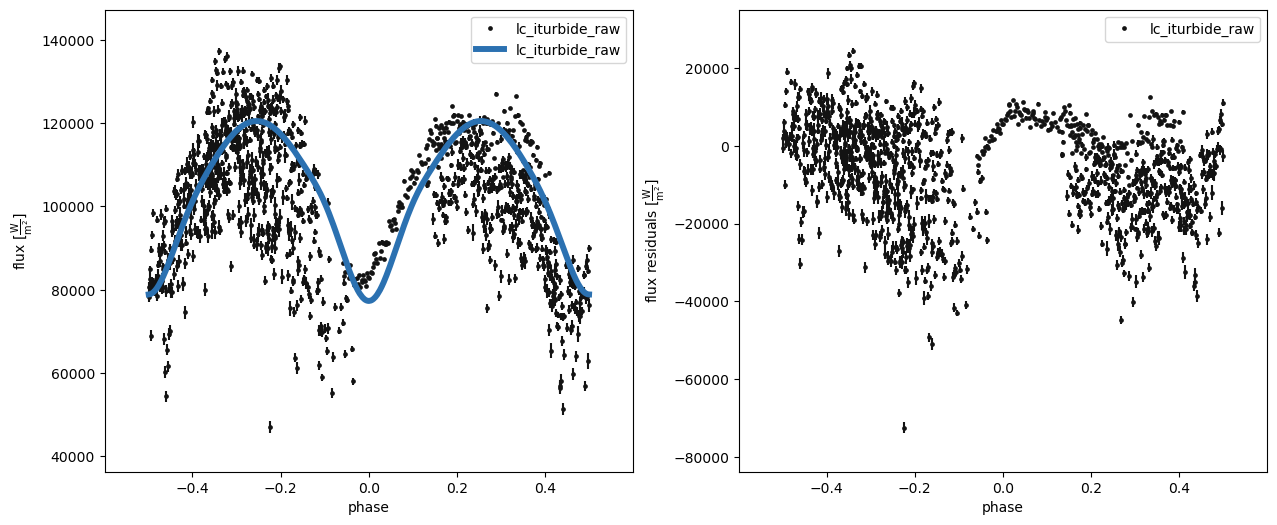

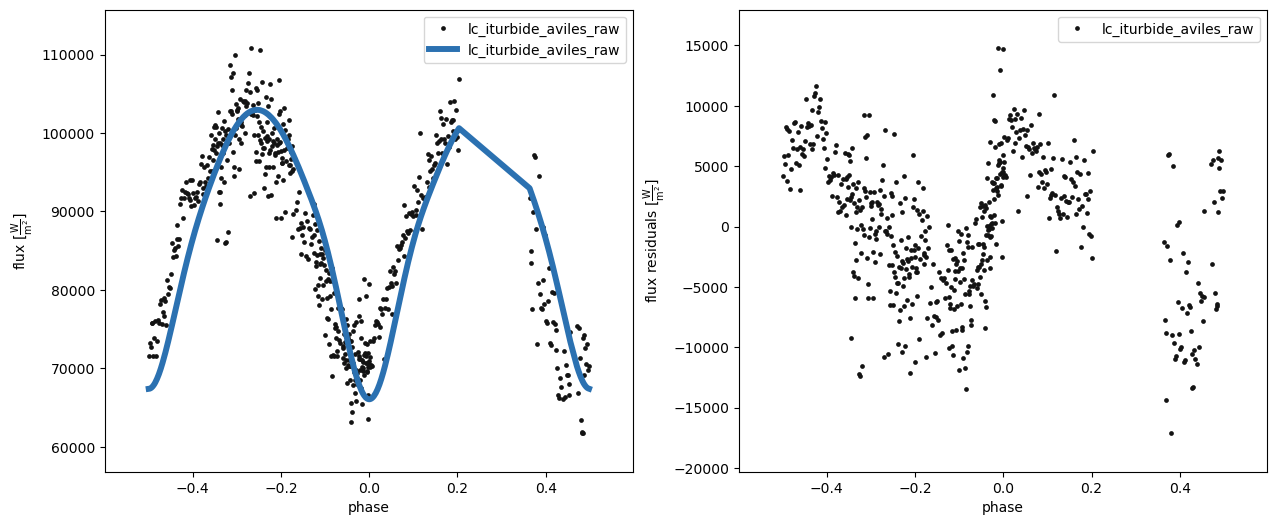

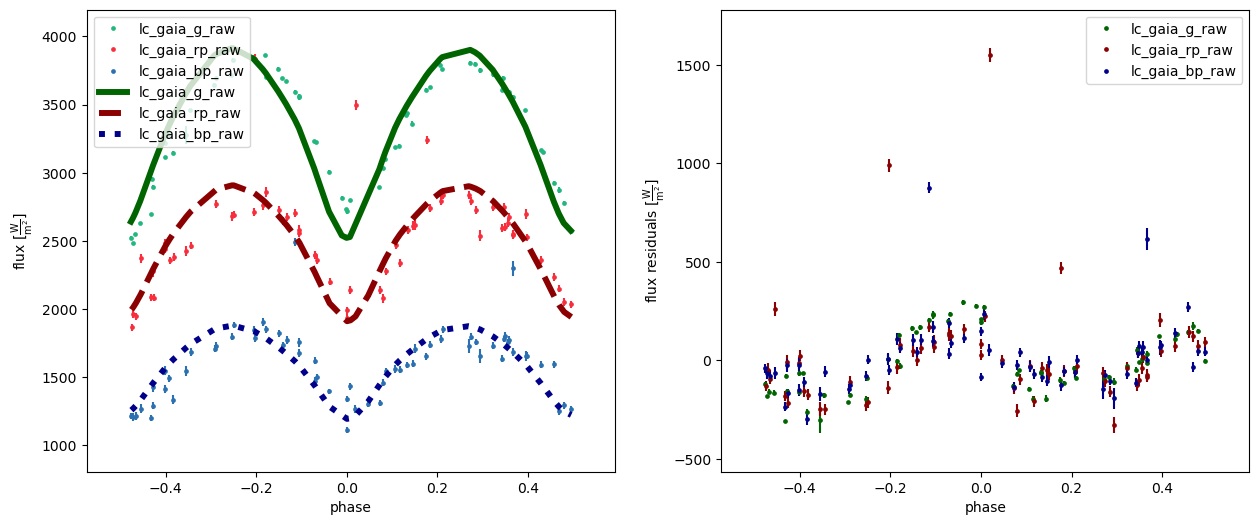

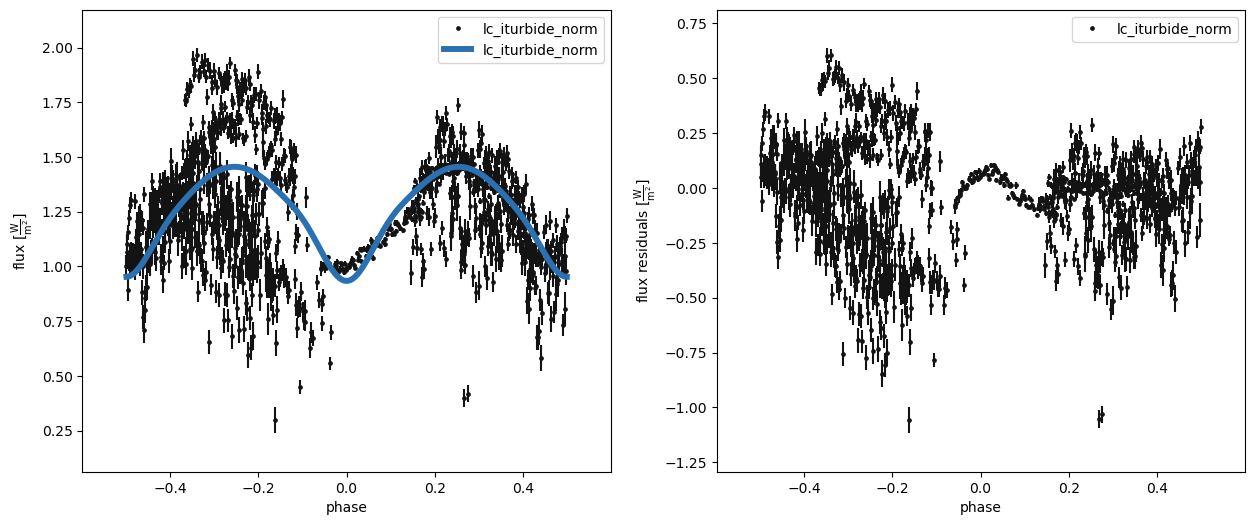

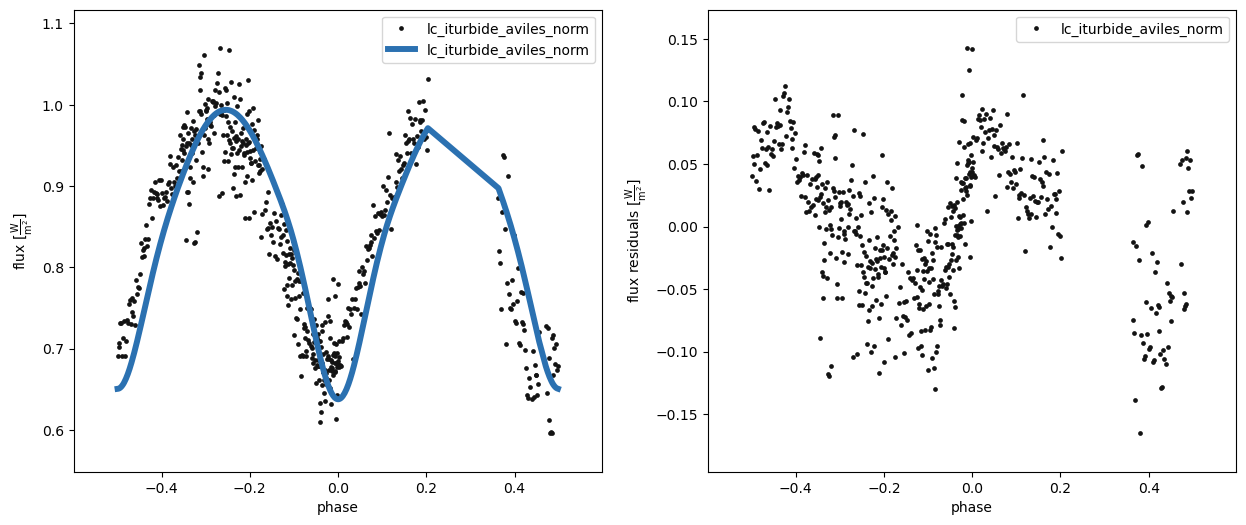

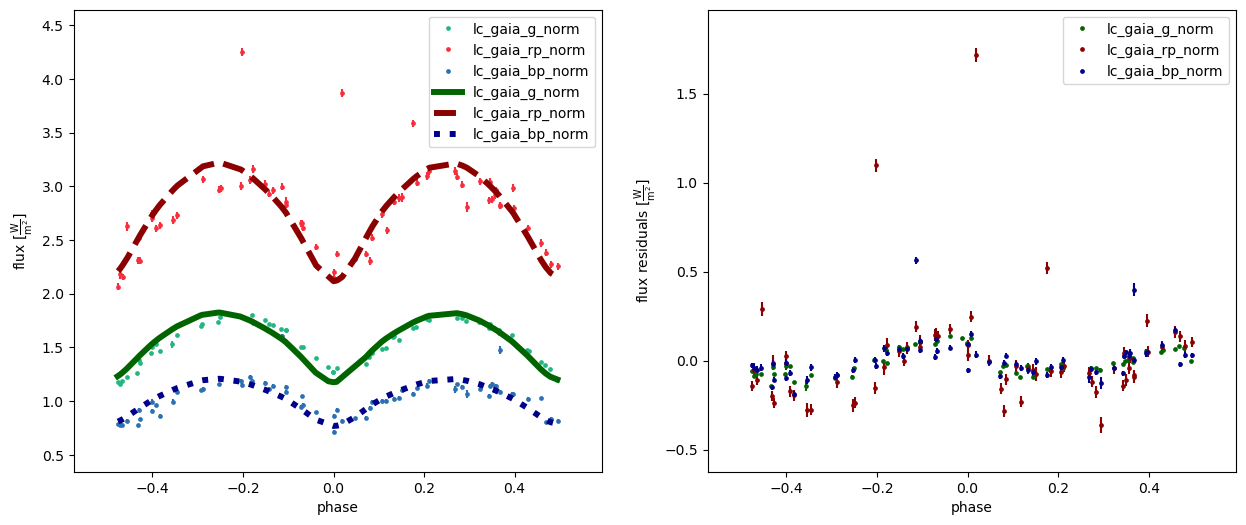

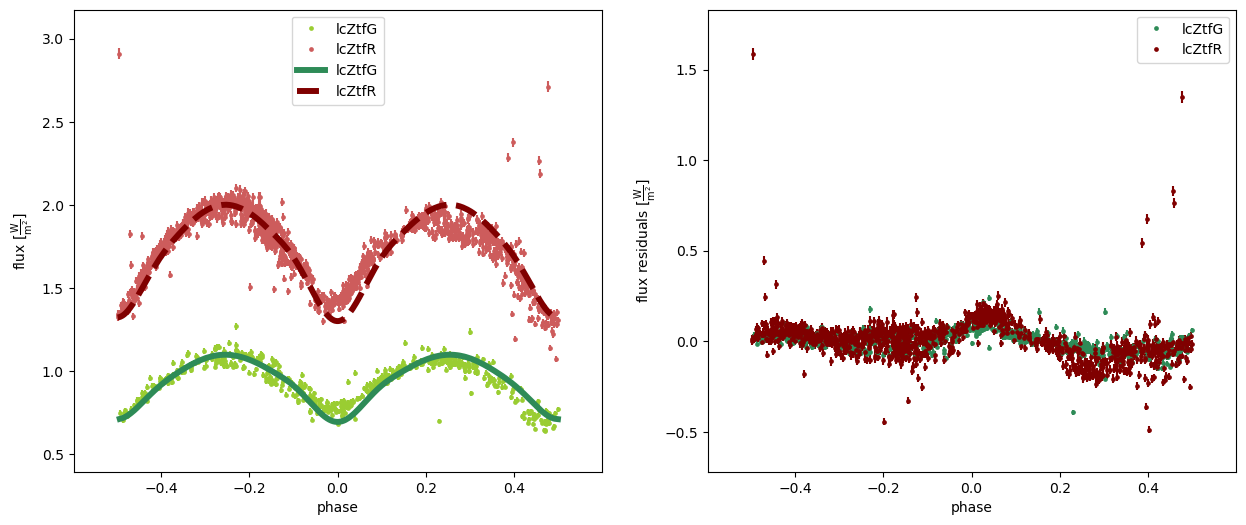

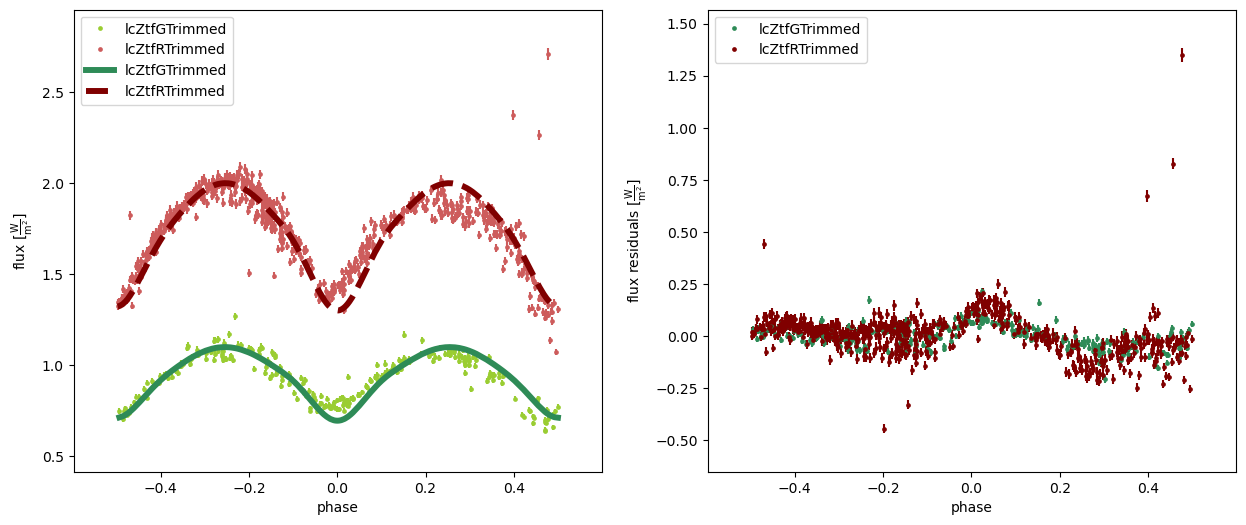

In [6]:
b.run_compute(model='before_optimizers', overwrite=True)
gen_utils.printChi2(b, 'before_optimizers')
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(15, 6), datasetGroups=allDatasetPlotGroups + [trimmedZtfDatasets], model='before_optimizers')

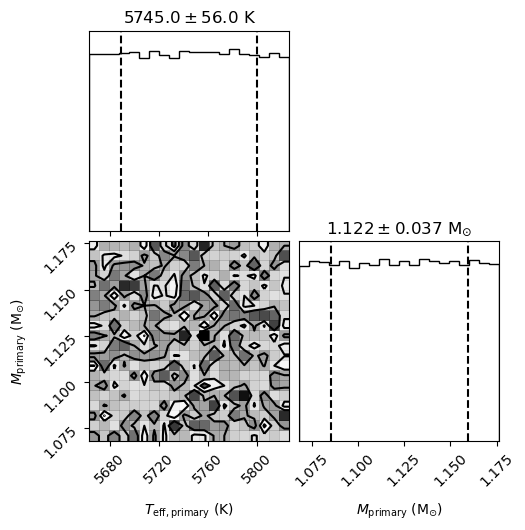

In [7]:
_ = b.plot_distribution_collection('poro_porb_bounds')

# Initial Parameters

## Sampling Poro Mass Distribution

Finding photometric solution using Poro empirical mass distribution. Primary component mass will be assumed to be sample.

In [12]:
# TODO: set secondary mass to Poro distribution sample
	# Poro distribution used to find mass of more massive component, which, given the current q, is the *secondary*
	# maybe a bit of conflicting results; hotter star is now less massive star
print(b['q'])
print(b['mass'])

ParameterSet: 2 parameters
C              q@binary@component: 1.8564781150410863
                     q@constraint: {mass@secondary@component} / {mass@primary@component}
ParameterSet: 3 parameters
           mass@primary@component: 1.1329322323227256 solMass
         mass@secondary@component: 2.1032638951317835 solMass
   mass@poro_porb_bounds@distr...: <distl.uniform low=1.0683323801509998 high=1.1763674300009999 unit=solMass label=mass@primary label_latex=$M_\mathrm{ primary }$>


In [19]:
poroDist, _ = b.get_distribution_collection('poro_porb_bounds')
_, massSample = poroDist.sample()
print(f"Sampled mass: {massSample}")
# b.set_value(qualifier='mass', component='primary', context='component', value=massSample)

# manually indirectly setting secondary's mass to sample
	# obtaining photometric solution for low mass components, to coincide with spectrum
	# true masses cannot be known without RV curve
primaryMass = massSample / b.get_value(qualifier='q')
b.set_value(qualifier='mass', component='primary', context='component', value=primaryMass)
b.run_all_constraints()
print(b['mass'])

Sampled mass: 1.1707282435365711
ParameterSet: 4 parameters
           mass@primary@component: 0.6306178532627956 solMass
C        mass@secondary@component: 1.1707282435365711 solMass
                  mass@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * ((1.000000 / {q@binary@component}) + 1.000000)) * 2942.206217504419328179210424423218)
   mass@poro_porb_bounds@distr...: <distl.uniform low=1.0683323801509998 high=1.1763674300009999 unit=solMass label=mass@primary label_latex=$M_\mathrm{ primary }$>


100%|██████████| 3673/3673 [08:03<00:00,  7.60it/s]
Mon, 22 Jan 2024 15:25 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0008344892206263245 for dataset='lc_iturbide_aviles_norm'


poro_sample
	 Gaia (Raw) - 19778.22384156107
		 lc_gaia_g_raw - 13248.378317623776
		 lc_gaia_rp_raw - 4308.190698849705
		 lc_gaia_bp_raw - 2221.654825087588
------------------------------------------------
	 Iturbide (Aviles) (Norm) - 1.689023959560849
	 Iturbide (Full) (Norm) - 43823.06990214859
	 ZTF - 32206.78141763076
		 lcZtfG - 7526.465520666621
		 lcZtfR - 24680.315896964137


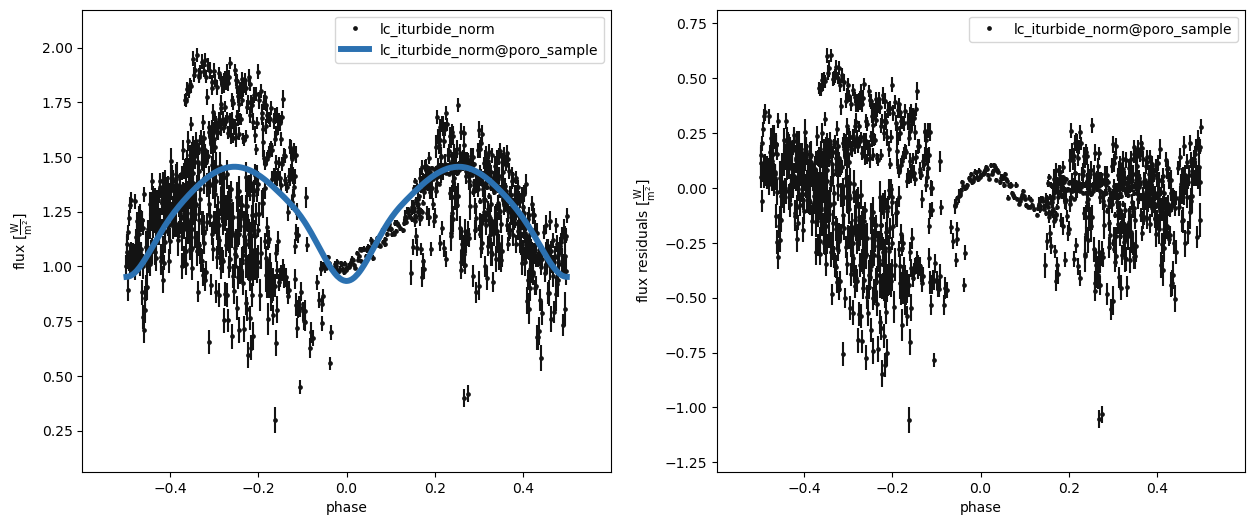

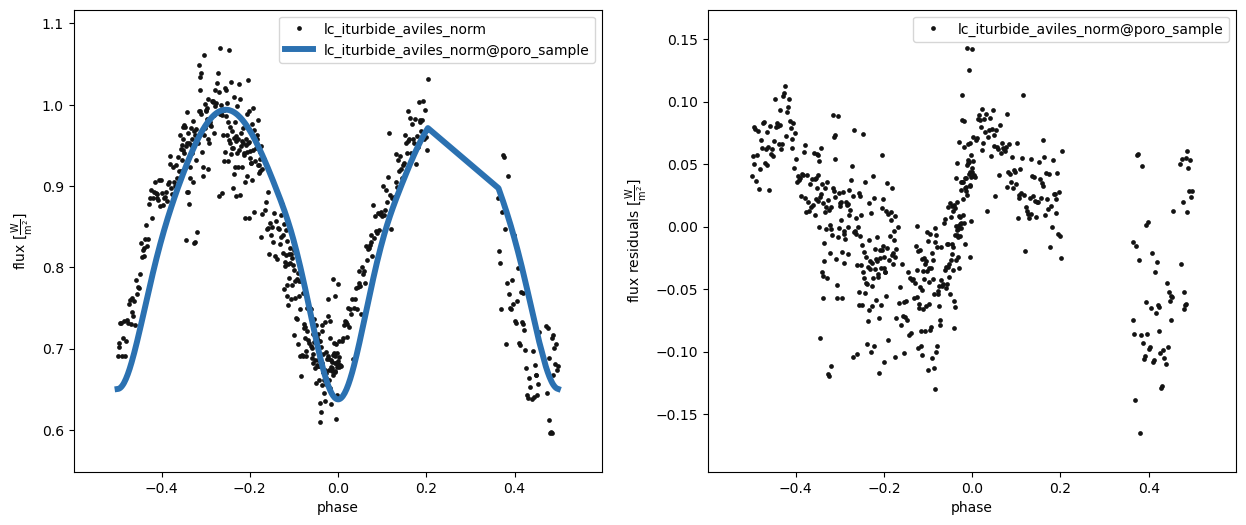

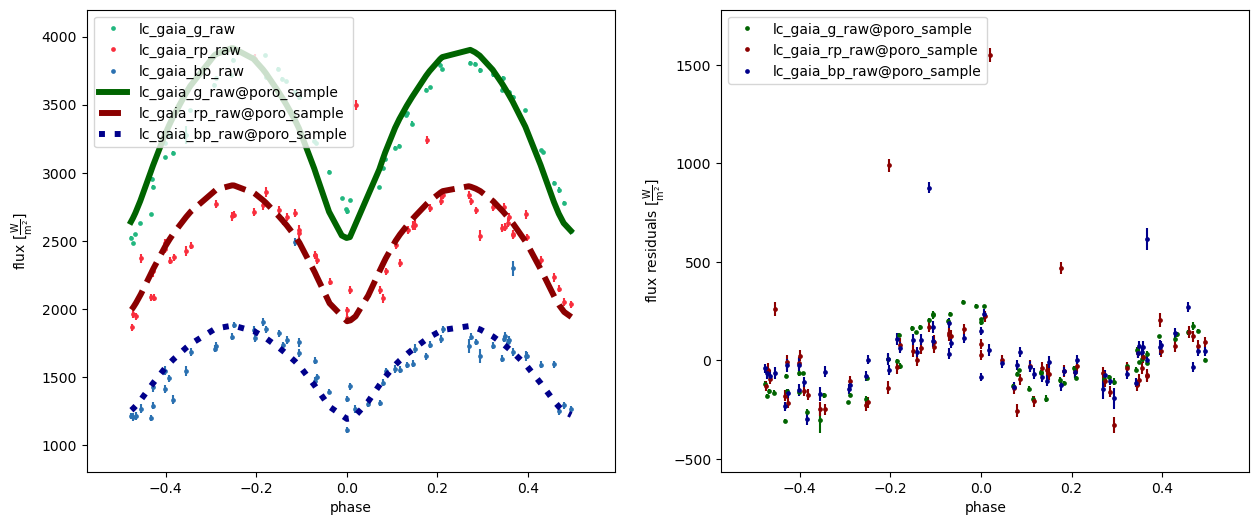

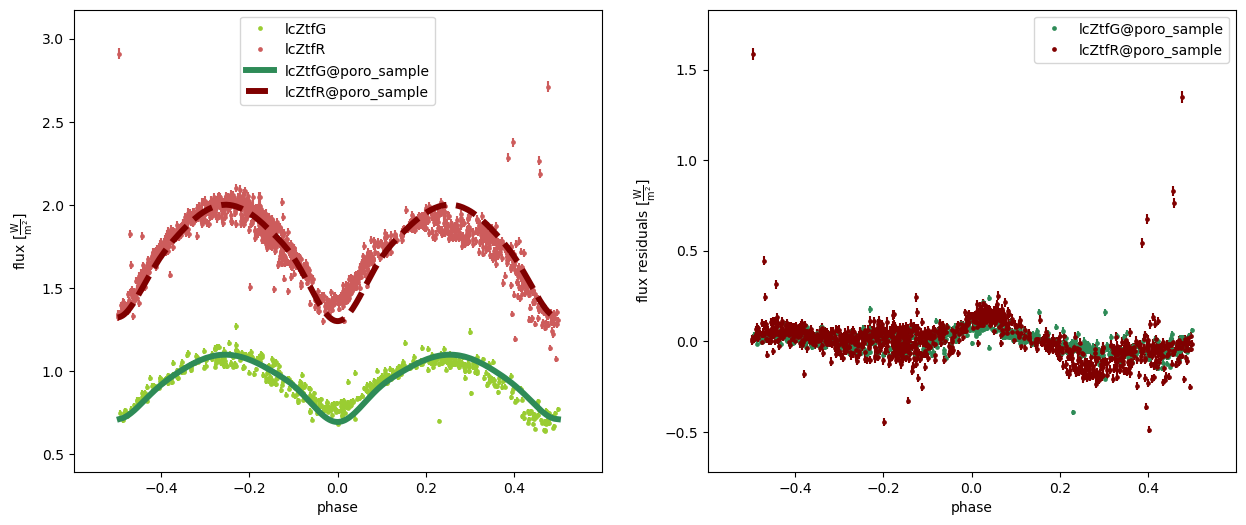

<Figure size 800x600 with 0 Axes>

In [20]:
gen_utils.abilitateDatasets(b, ['lc_iturbide_norm', 'lc_iturbide_aviles_norm'] + rawGaiaDatasets + ztfDatasets)
b.run_compute(model='poro_sample', overwrite=True)
gen_utils.printChi2(b, 'poro_sample')
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(15, 6), datasetGroups=[['lc_iturbide_norm'], ['lc_iturbide_aviles_norm'], rawGaiaDatasets, ztfDatasets], model='poro_sample')
_ = gen_utils.animateMesh(b, logger, model='poro_sample')

In [21]:
print(b['q'])
print(b['mass'])
print(b['requiv'])
print(b['teff'])
print(b['teffratio'])
print(b['fillout_factor'])
print(b['incl@binary'])

Parameter: q@binary@component
                       Qualifier: q
                     Description: Mass ratio
                           Value: 1.8564781150410863
                  Constrained by: 
                      Constrains: requiv@primary@component, requiv@secondary@component, pot@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, sma@binary@component, sma@primary@component, asini@primary@component, requiv_max@primary@component, requiv_min@primary@component, sma@secondary@component, asini@secondary@component, requiv_max@secondary@component, requiv_min@secondary@component
                      Related to: pot@contact_envelope@component, sma@binary@component, requiv@primary@component, requiv@secondary@component, fillout_factor@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, mass@primary@component, period@binary@component, sma@primary@component, incl@binary@component, asini@primar

In [22]:
# disabling for now; all optimizers were run on full ZTF data, no need to check right now that trimmed datasets match
b.set_value_all(qualifier='enabled', dataset=trimmedZtfDatasets, value=False)
print(b['enabled'])

ParameterSet: 15 parameters
   enabled@mesh01@phoebe01@com...: True
   enabled@lc_iturbide_norm@ph...: True
   enabled@lc_iturbide_raw@pho...: False
   enabled@lc_iturbide_aviles_...: True
   enabled@lc_iturbide_aviles_...: False
   enabled@lc_gaia_g_norm@phoe...: False
   enabled@lc_gaia_rp_norm@pho...: False
   enabled@lc_gaia_bp_norm@pho...: False
   enabled@lc_gaia_g_raw@phoeb...: True
   enabled@lc_gaia_rp_raw@phoe...: True
   enabled@lc_gaia_bp_raw@phoe...: True
   enabled@lcZtfG@phoebe01@com...: True
   enabled@lcZtfR@phoebe01@com...: True
   enabled@lcZtfGTrimmed@phoeb...: False
   enabled@lcZtfRTrimmed@phoeb...: False


# Period and `t0_supconj`

Eclipse timings look off from model to light curves, from slight positional offset.

In [23]:
opt_utils.optimize_params(b, fit_twigs=['period@binary', 't0_supconj'], label='per_t0', export=True, subfolder="iturbide-gaia-ztf-relative_norm", overwrite_export=False,
						  datasets=['lc_iturbide_norm', 'lc_iturbide_aviles_norm'] + normGaiaDatasets + ztfDatasets, maxiter=200)

Solver already exists | ./external-jobs/iturbide-gaia-ztf-relative_norm/optimizer.nelder_mead_opt_per_t0.py


('opt_per_t0', 'opt_per_t0_solution')

Mon, 22 Jan 2024 16:04 BUNDLE       WARNING not all uniqueids in fitted_uniqueids@opt_per_t0_solution@solution are still valid.  Falling back on twigs.  Save and load same bundle to prevent this extra cost.


Adopted:
period@binary@orbit@component 0.33357 d 
t0_supconj@binary@orbit@component -0.03754 d 

Original values:
  period@binary@orbit@component 0.33356598071006005 d 
  t0_supconj@binary@orbit@component -0.037542756559644994 d 


100%|██████████| 3673/3673 [08:02<00:00,  7.61it/s]
Mon, 22 Jan 2024 16:12 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0008344892206263245 for dataset='lc_iturbide_aviles_norm'


before_optimizers
	 Iturbide (Aviles) (Raw) - 18109217111.55099
	 Iturbide (Full) (Raw) - 265597.22928488976
	 Gaia (Raw) - 19757.86303394764
		 lc_gaia_g_raw - 13229.176693503568
		 lc_gaia_rp_raw - 4308.280464088301
		 lc_gaia_bp_raw - 2220.4058763557705
------------------------------------------------
	 Iturbide (Aviles) (Norm) - 1.6873189139604858
	 Iturbide (Full) (Norm) - 43816.40841331415
	 Gaia (Norm) - 19757.863033947688
		 lc_gaia_g_norm - 13229.176693503621
		 lc_gaia_rp_norm - 4308.2804640883
		 lc_gaia_bp_norm - 2220.405876355764
	 ZTF - 47718.90388726734
		 lcZtfG - 7510.758185009431
		 lcZtfR - 24668.343851277346
		 lcZtfGTrimmed - 3564.0674563692423
		 lcZtfRTrimmed - 11975.734394611316
poro_sample
	 Gaia (Raw) - 19778.22384156107
		 lc_gaia_g_raw - 13248.378317623776
		 lc_gaia_rp_raw - 4308.190698849705
		 lc_gaia_bp_raw - 2221.654825087588
------------------------------------------------
	 Iturbide (Aviles) (Norm) - 1.689023959560849
	 Iturbide (Full) (Norm) - 43823.

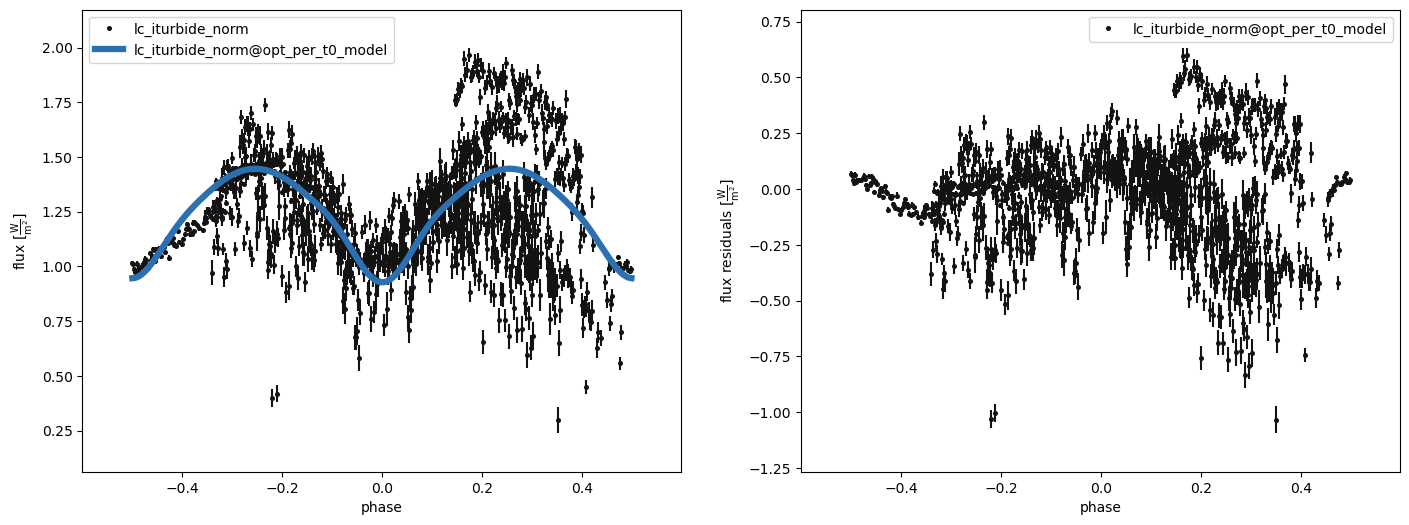

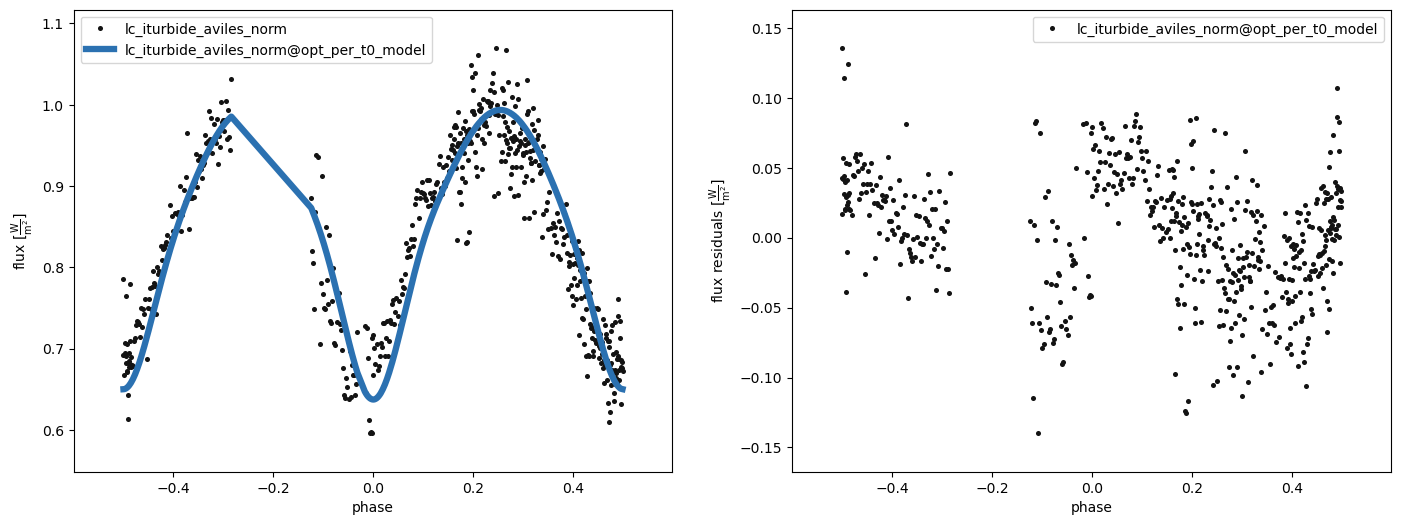

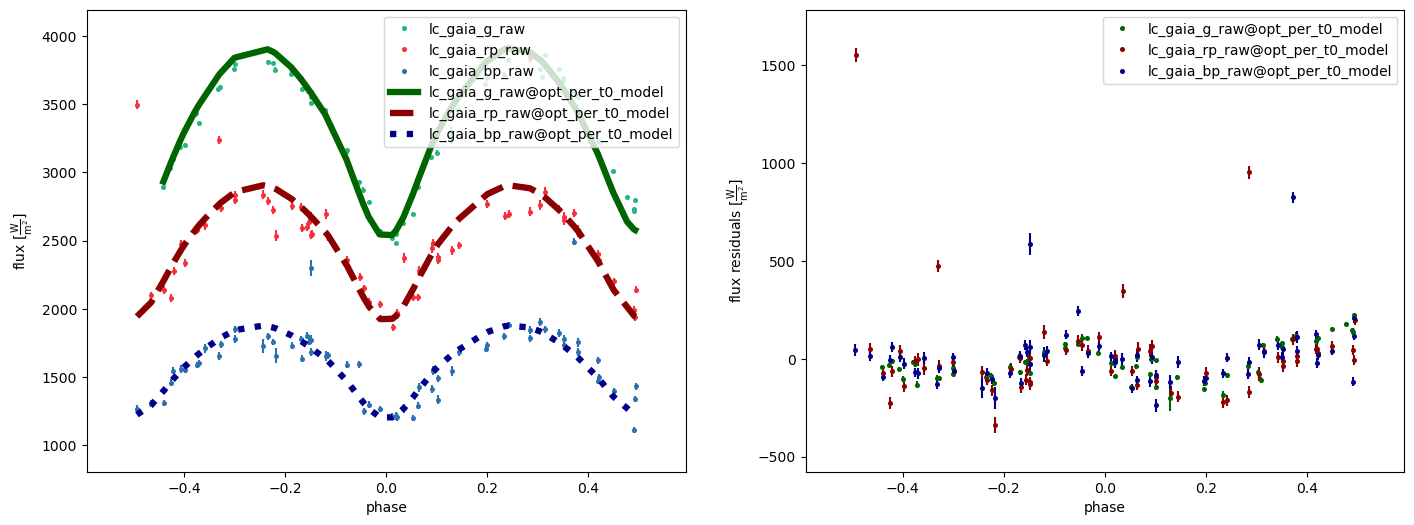

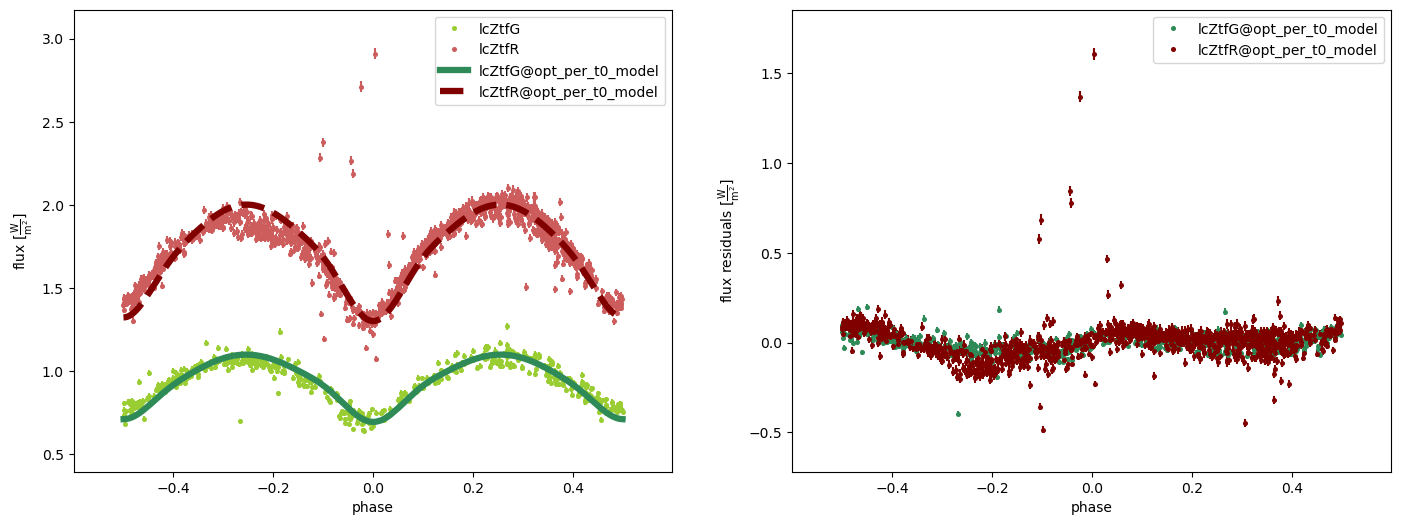

In [26]:
# using previous normalization solution; *should* be an applicable solution
gen_utils.abilitateDatasets(b, ['lc_iturbide_norm', 'lc_iturbide_aviles_norm'] + rawGaiaDatasets + ztfDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/iturbide-gaia-ztf-ltt/results/opt_per_t0_solution", reset_params=False)
gen_utils.printAllModelsChi2(b)
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(17, 6), datasetGroups=[['lc_iturbide_norm'], ['lc_iturbide_aviles_norm'], rawGaiaDatasets, ztfDatasets], model=computeModelName)

# Eclipse Width and Depth

Adjusting $T_{eff}$ ratio (`teffratio`) based on eclipse depths, alongside the fillout factor (`fillout_factor`) to adjust the eclipse widths. Fillout factor
parametrization of component radii.

In [27]:
opt_utils.optimize_params(b, ['teffratio', 'fillout_factor'], "teffr_ff_vis", export=True, subfolder="iturbide-gaia-ztf-relative_norm", overwrite_export=False,
						  datasets=['lc_iturbide_norm', 'lc_iturbide_aviles_norm'] + normGaiaDatasets + ztfDatasets, maxiter=200)

Solver already exists | ./external-jobs/iturbide-gaia-ztf-relative_norm/optimizer.nelder_mead_opt_teffr_ff_vis.py


('opt_teffr_ff_vis', 'opt_teffr_ff_vis_solution')

Adopted:
teffratio@binary@orbit@component 0.96753  
fillout_factor@contact_envelope@envelope@component 0.03527  

Original values:
  teffratio@binary@orbit@component 0.9857284692267768 
  fillout_factor@contact_envelope@envelope@component 0.1852193760747716 


100%|██████████| 3657/3657 [08:24<00:00,  7.25it/s]
Mon, 22 Jan 2024 16:23 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0008344892206263245 for dataset='lc_iturbide_aviles_norm'


before_optimizers
	 Iturbide (Aviles) (Raw) - 18109217111.55099
	 Iturbide (Full) (Raw) - 265597.22928488976
	 Gaia (Raw) - 19757.86303394764
		 lc_gaia_g_raw - 13229.176693503568
		 lc_gaia_rp_raw - 4308.280464088301
		 lc_gaia_bp_raw - 2220.4058763557705
------------------------------------------------
	 Iturbide (Aviles) (Norm) - 1.6873189139604858
	 Iturbide (Full) (Norm) - 43816.40841331415
	 Gaia (Norm) - 19757.863033947688
		 lc_gaia_g_norm - 13229.176693503621
		 lc_gaia_rp_norm - 4308.2804640883
		 lc_gaia_bp_norm - 2220.405876355764
	 ZTF - 47718.90388726734
		 lcZtfG - 7510.758185009431
		 lcZtfR - 24668.343851277346
		 lcZtfGTrimmed - 3564.0674563692423
		 lcZtfRTrimmed - 11975.734394611316
poro_sample
	 Gaia (Raw) - 19778.22384156107
		 lc_gaia_g_raw - 13248.378317623776
		 lc_gaia_rp_raw - 4308.190698849705
		 lc_gaia_bp_raw - 2221.654825087588
------------------------------------------------
	 Iturbide (Aviles) (Norm) - 1.689023959560849
	 Iturbide (Full) (Norm) - 43823.

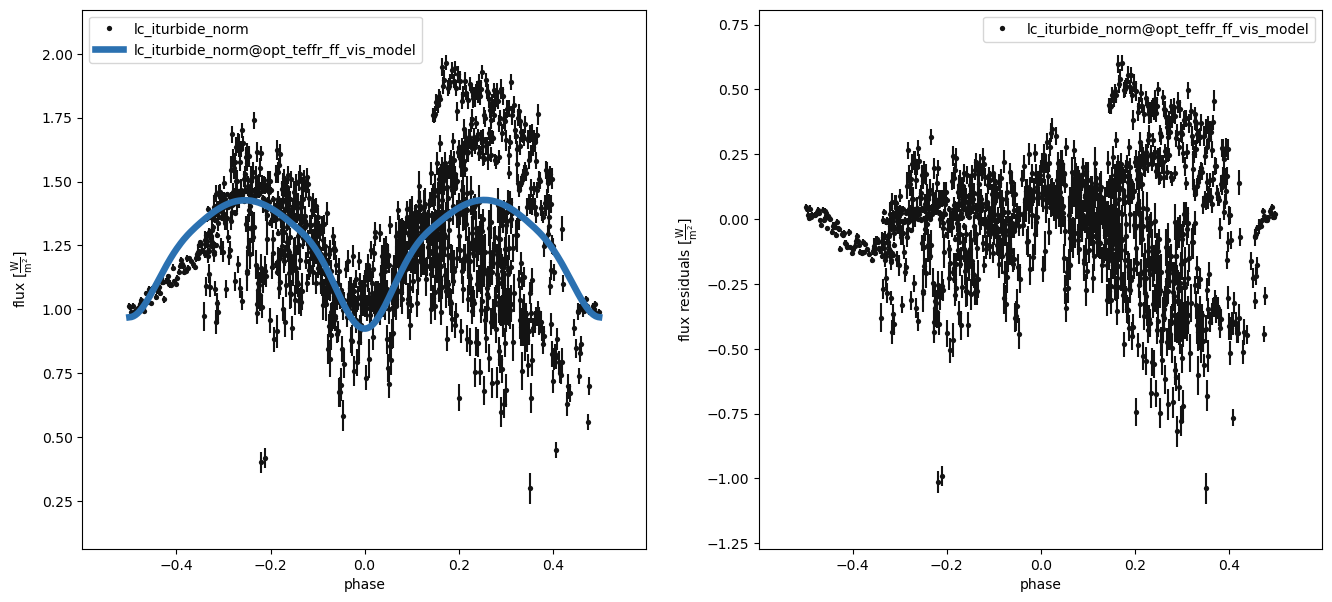

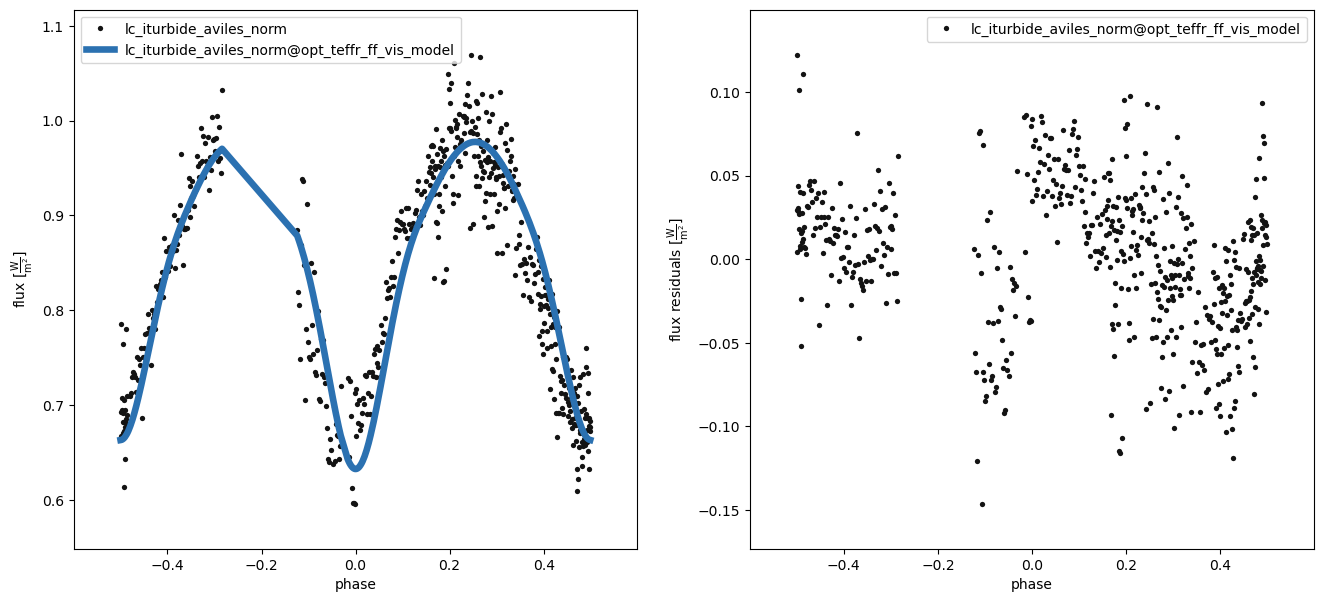

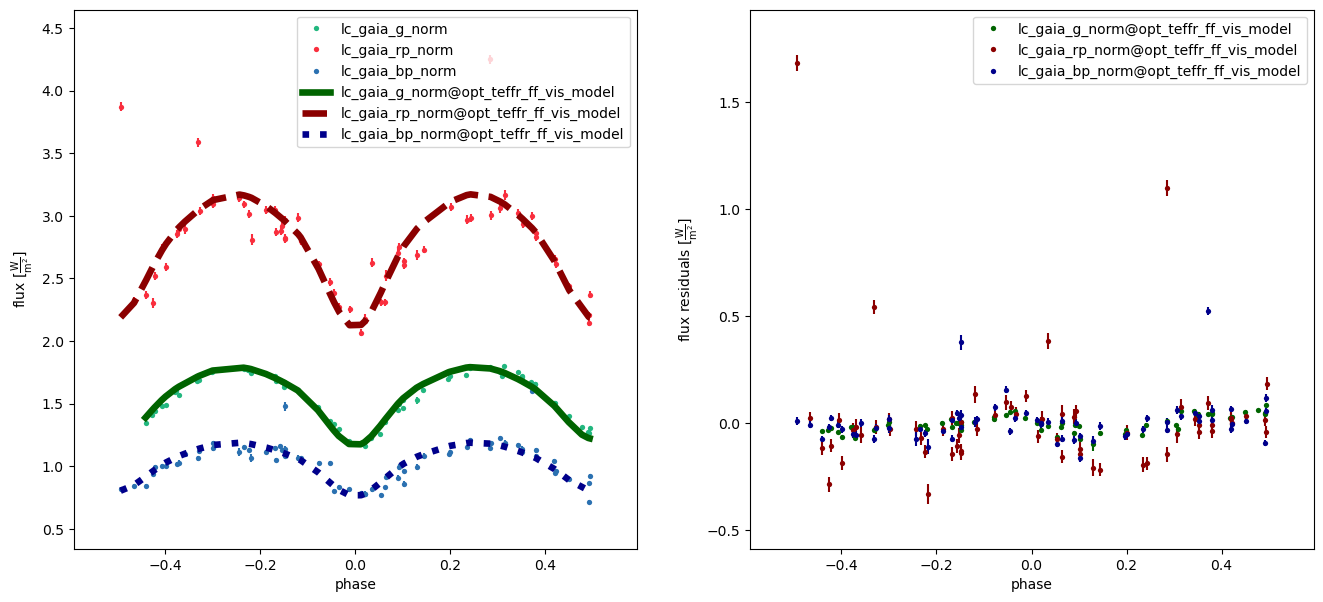

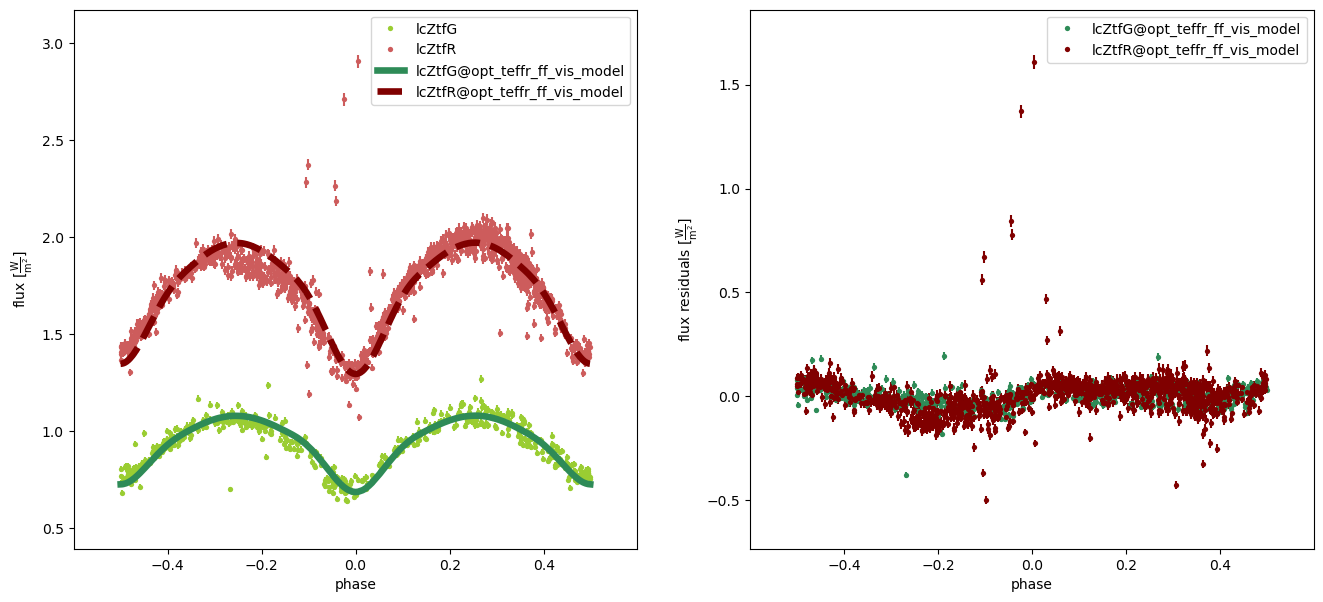

In [28]:
gen_utils.abilitateDatasets(b, ['lc_iturbide_norm', 'lc_iturbide_aviles_norm'] + normGaiaDatasets + ztfDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/iturbide-gaia-ztf-relative_norm/results/opt_teffr_ff_vis_solution", 
														  reset_params=False, dataset=['lc_iturbide_norm', 'lc_iturbide_aviles_norm'] + normGaiaDatasets + ztfDatasets)
gen_utils.printAllModelsChi2(b)
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(16, 7), datasetGroups=normDatasetPlotGroups, model=computeModelName)

# Sunspot Feature

Including a starspot to account for *O'Connell effect* seen in ZTF LCs.

In [29]:
b.flip_constraint(qualifier='compute_phases', dataset='mesh01', solve_for='compute_times')
b.set_value(qualifier='compute_phases', dataset='mesh01', context='dataset', value=phoebe.linspace(-0.5, 0.5, 20))

In [32]:
gen_utils.abilitateDatasets(b, [])
b.run_compute(model='updated_mesh_phases', overwrite=True)

100%|██████████| 20/20 [00:02<00:00,  7.49it/s]


<ParameterSet: 203 parameters | components: primary, secondary>

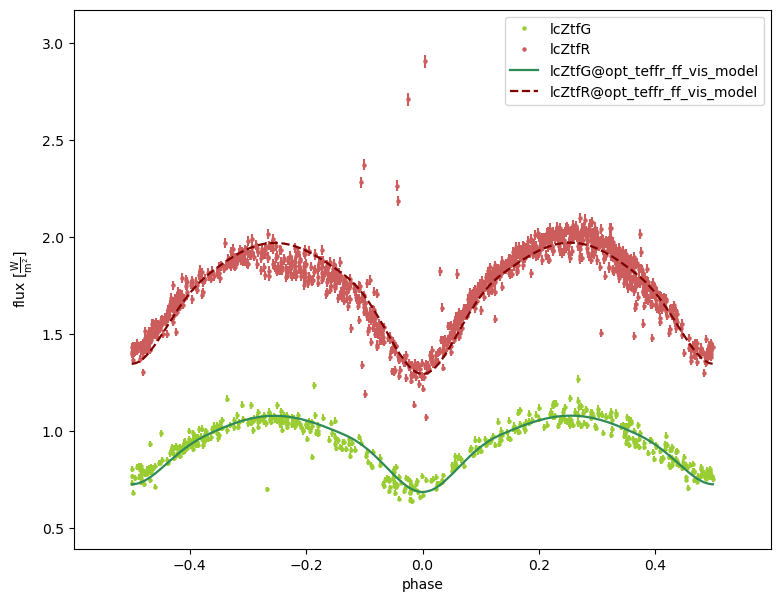

Mon, 22 Jan 2024 16:42 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.059016, assuming named color
Mon, 22 Jan 2024 16:42 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.059016, assuming named color


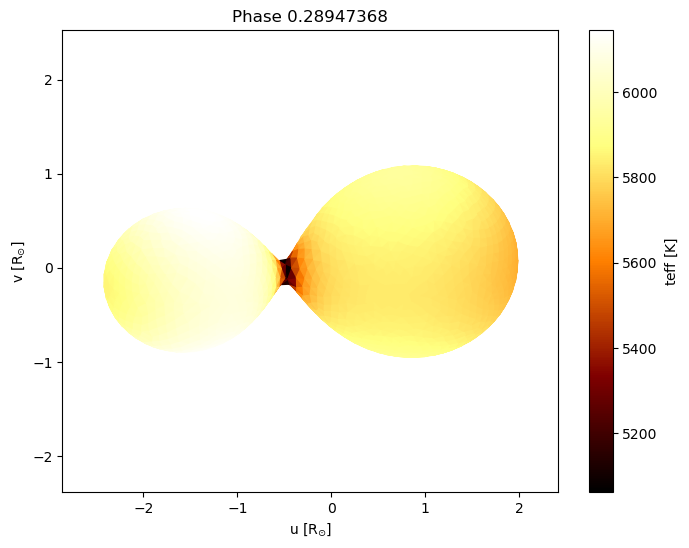

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 800x600 with 2 Axes>)

In [33]:
phase = 0.28947368
fig = plt.figure(figsize=(9, 7))
b.plot(x='phase', dataset=ztfDatasets, model='opt_teffr_ff_vis_model', color=gen_utils.ZTF_PLOT_COLORS, marker={'dataset': '.'}, fig=fig, legend=True, s=0.009, show=True)
b.plot(dataset='mesh01', kind='mesh', fc='teffs', ec='face', phase=phase, draw_sidebars=True, model='updated_mesh_phases', show=True, title=f"Phase {phase}", draw_title=True)

## Secondary Spot

In [34]:
b.add_spot(component='secondary', feature='secondary_spot', overwrite=True)

<ParameterSet: 5 parameters | contexts: feature, compute>

100%|██████████| 878/878 [02:03<00:00,  7.09it/s]
Mon, 22 Jan 2024 16:44 PARAMETERS   WARNING could not find Parameter match for ec=face at time=-0.116545, assuming named color
Mon, 22 Jan 2024 16:44 PARAMETERS   WARNING could not find Parameter match for ec=face at time=-0.116545, assuming named color


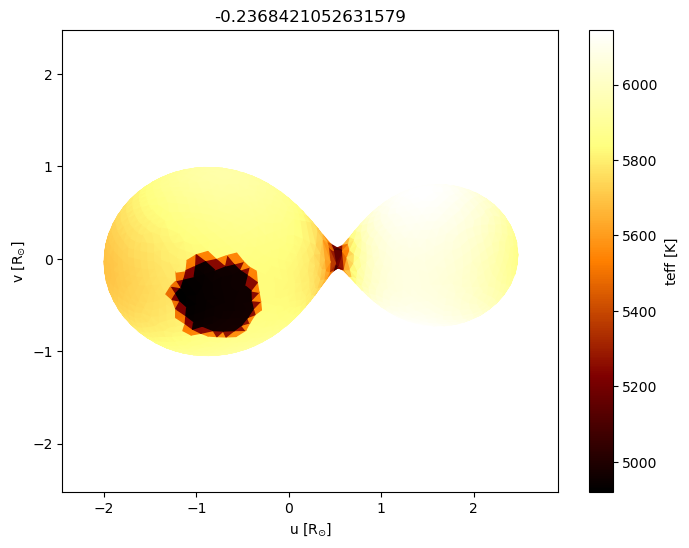

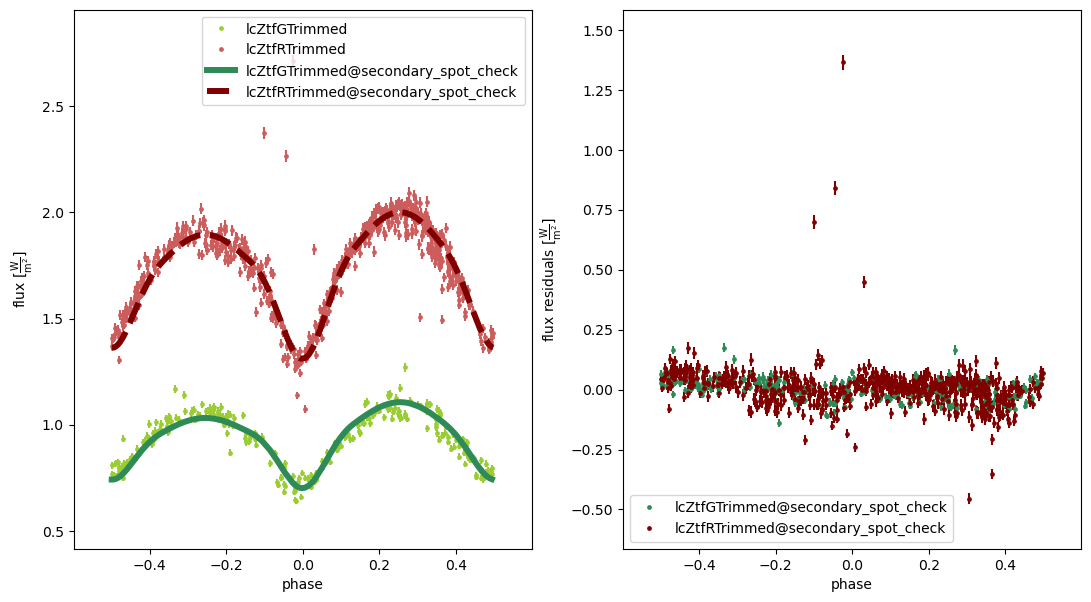

{'lcZtfGTrimmed-lcZtfRTrimmed': <Figure size 1300x700 with 2 Axes>}

In [35]:
# initial conditions for secondary spot; rough estimates based on light curve shape, giving the optimizer a starting point
gen_utils.abilitateDatasets(b, trimmedZtfDatasets)

b.set_value(qualifier='relteff', feature='secondary_spot', value=0.85)
b.set_value(qualifier='radius', feature='secondary_spot', value=25)
b.set_value(qualifier='colat', feature='secondary_spot', value=85)
b.set_value(qualifier='long', feature='secondary_spot', value=-90)

b.run_compute(model='secondary_spot_check', overwrite=True)
meshComputePhases = b.get_value(qualifier='compute_phases', dataset='mesh01', context='dataset')
plotPhase = meshComputePhases[len(meshComputePhases) // 4]
b.plot(dataset='mesh01', phase=plotPhase, model='secondary_spot_check', fc='teffs', ec='face', show=True, draw_sidebars=True, title=str(plotPhase), draw_title=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[trimmedZtfDatasets], model='secondary_spot_check')

In [36]:
opt_utils.optimize_params(b, fit_twigs=['colat@secondary_spot', 'long@secondary_spot', 'radius@secondary_spot', 'relteff@secondary_spot'], 
						  label='secondary_spot', export=True, subfolder="iturbide-gaia-ztf-relative_norm", datasets=trimmedZtfDatasets, maxiter=250)

External Solver: ./external-jobs/iturbide-gaia-ztf-relative_norm/optimizer.nelder_mead_opt_secondary_spot.py ./results/opt_secondary_spot_solution


('opt_secondary_spot', 'opt_secondary_spot_solution')

Mon, 22 Jan 2024 16:44 BUNDLE       WARNING not all uniqueids in fitted_uniqueids@opt_secondary_spot_solution@solution are still valid.  Falling back on twigs.  Save and load same bundle to prevent this extra cost.


Adopted:
colat@secondary_spot@secondary@spot@feature 87.45163 deg 
long@secondary_spot@secondary@spot@feature 250.88311 deg 
radius@secondary_spot@secondary@spot@feature 25.15923 deg 
relteff@secondary_spot@secondary@spot@feature 0.88344  

Original values:
  colat@secondary_spot@secondary@spot@feature 85.0 deg 
  long@secondary_spot@secondary@spot@feature 270.0 deg 
  radius@secondary_spot@secondary@spot@feature 25.0 deg 
  relteff@secondary_spot@secondary@spot@feature 0.85 


100%|██████████| 1735/1735 [04:00<00:00,  7.21it/s]


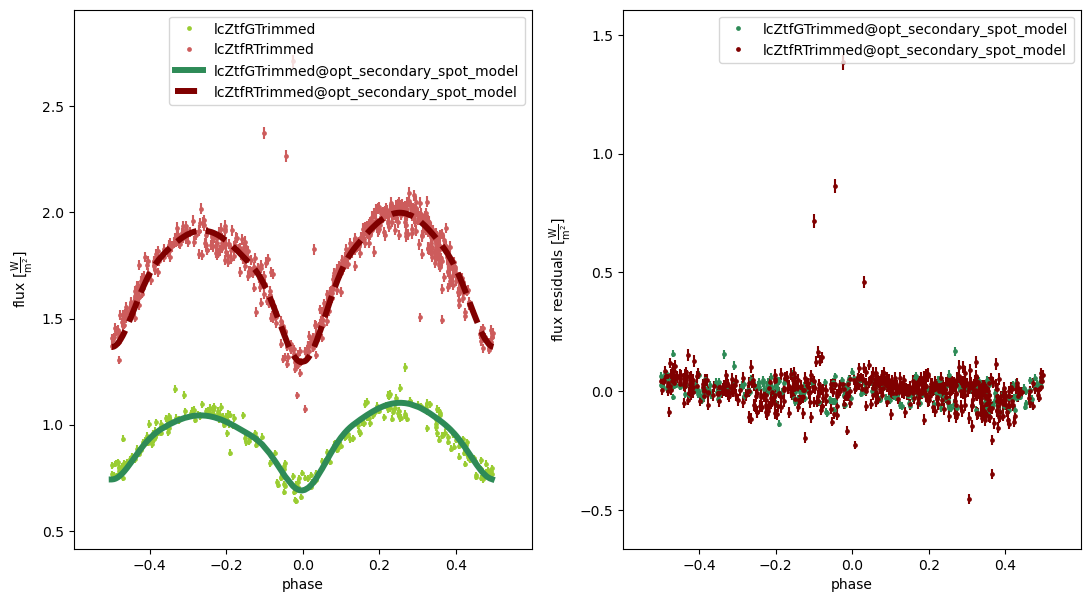

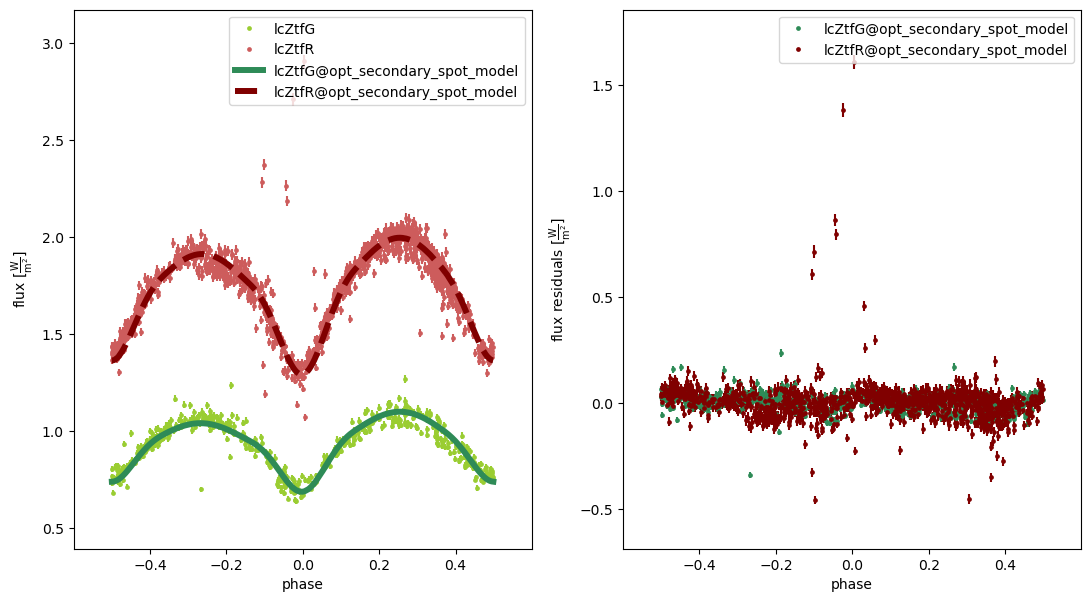

<Figure size 800x600 with 0 Axes>

In [37]:
gen_utils.abilitateDatasets(b, trimmedZtfDatasets + ztfDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, reset_params=False, solution_file="./external-jobs/iturbide-gaia-ztf-relative_norm/results/opt_secondary_spot_solution")
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[trimmedZtfDatasets, ztfDatasets], model=computeModelName)
gen_utils.animateMesh(b, logger, model=computeModelName)

100%|██████████| 1962/1962 [04:36<00:00,  7.11it/s]
Mon, 22 Jan 2024 16:54 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0008344892206263245 for dataset='lc_iturbide_aviles_norm'


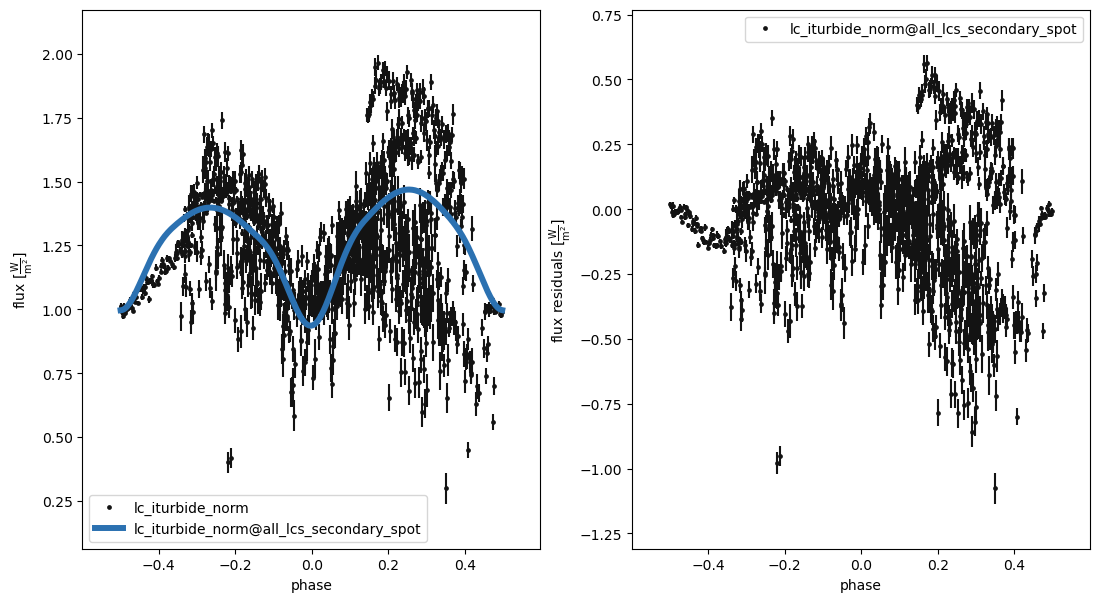

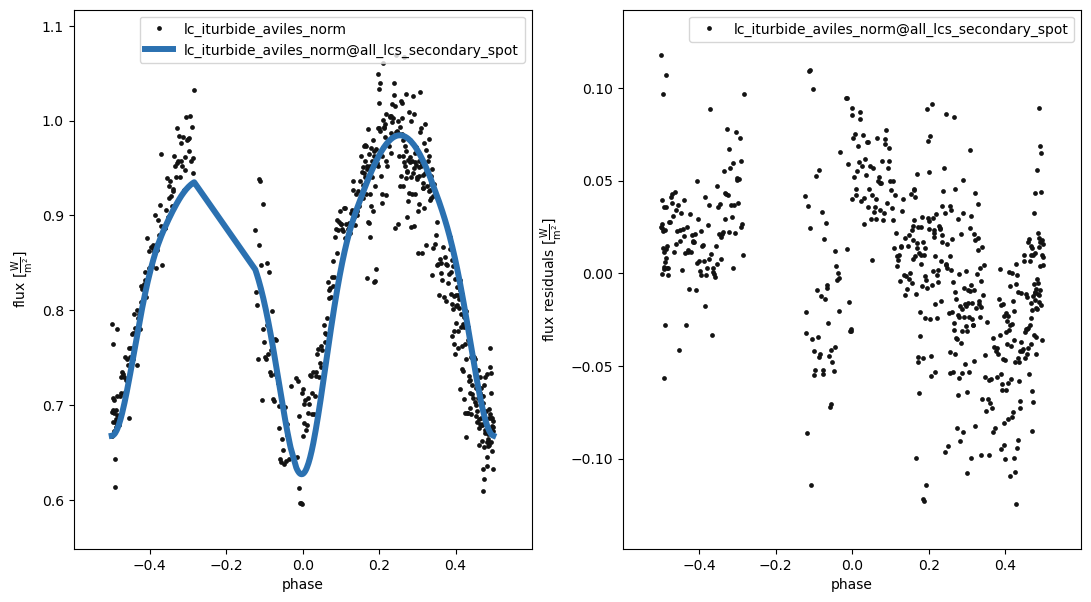

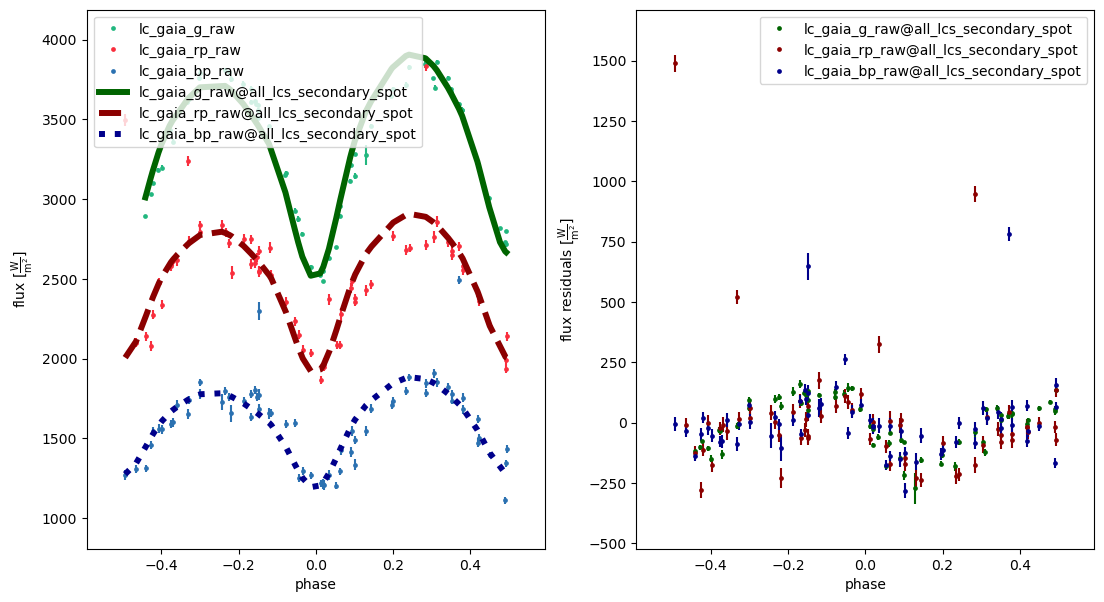

In [38]:
gen_utils.abilitateDatasets(b, rawGaiaDatasets + ['lc_iturbide_norm', 'lc_iturbide_aviles_norm'])
b.run_compute(model='all_lcs_secondary_spot', overwrite=True)
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[['lc_iturbide_norm'], ['lc_iturbide_aviles_norm'], rawGaiaDatasets], model='all_lcs_secondary_spot')

# Differential Optimization Adjustments

Parameter optimization through differential techniques to get closer to parameter space minimum. Trying out both `differential_evolution` and `differential_correction` optimizers, of which DE optimizer will run on remote server to take advantage of the greater amount of threads available for heavy usage.

Opted for executing DC optimizer in notebook directly, since `differential_correction` is single-threaded and therefore benefits most from single core speed. Current servers have ancient CPUs, which, while having an enormous amount of threads to work with, are painfully slow for single-threaded tasks.

In [39]:
# original values

print(b['teffratio'])
print(b['incl@binary'])
print(b['fillout_factor'])

Parameter: teffratio@binary@component
                       Qualifier: teffratio
                     Description: ratio between effective temperatures of children stars
                           Value: 0.9675251414419437
                  Constrained by: 
                      Constrains: teff@secondary@component
                      Related to: teff@primary@component, teff@secondary@component

Parameter: incl@binary@component
                       Qualifier: incl
                     Description: Orbital inclination angle
                           Value: 71.0744196944225 deg
                  Constrained by: 
                      Constrains: asini@binary@component, asini@primary@component, incl@primary@component, asini@secondary@component, incl@secondary@component
                      Related to: sma@binary@component, asini@binary@component, q@binary@component, asini@primary@component, pitch@primary@component, incl@primary@component, asini@secondary@component, pitch@secondary@

## Differential Evolution

In [ ]:
%%script echo "skipping; really bad residuals on both Gaia and ZTF now"

b.add_distribution({
	'teffratio': phoebe.uniform_around(0.08),
	'incl@binary': phoebe.uniform_around(8),
	'fillout_factor': phoebe.uniform_around(0.1),
	'period@binary': phoebe.uniform_around(0.02),
	't0_supconj@binary': phoebe.uniform_around(0.01)
}, distribution='de_bounds', overwrite_all=True)

opt_utils.optimize_params(b, fit_twigs=['teffratio', 'incl@binary', 'fillout_factor', 'period@binary', 't0_supconj@binary'], label='rel_de',
						  export=True, subfolder='iturbide-gaia-ztf-relative_norm', datasets=trimmedZtfDatasets + rawGaiaDatasets,
						  optimizer='optimizer.differential_evolution', bounds=['de_bounds'])

External Solver: ./external-jobs/iturbide-gaia-ztf-relative_norm/optimizer.differential_evolution_opt_rel_de.py ./results/opt_rel_de_solution


('opt_rel_de', 'opt_rel_de_solution')

Adopted:
teffratio@binary@orbit@component 1.00589  
incl@binary@orbit@component 69.23590 deg 
fillout_factor@contact_envelope@envelope@component 0.07407  
period@binary@orbit@component 0.33357 d 
t0_supconj@binary@orbit@component -0.03254 d 

Original values:
  teffratio@binary@orbit@component 0.9675251414419437 
  incl@binary@orbit@component 71.0744196944225 deg 
  fillout_factor@contact_envelope@envelope@component 0.035265041942818764 
  period@binary@orbit@component 0.33356598071006005 d 
  t0_supconj@binary@orbit@component -0.037542756559644994 d 


100%|██████████| 3677/3677 [08:28<00:00,  7.23it/s]
Mon, 22 Jan 2024 12:45 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0008344892206263245 for dataset='lc_iturbide_aviles_norm'


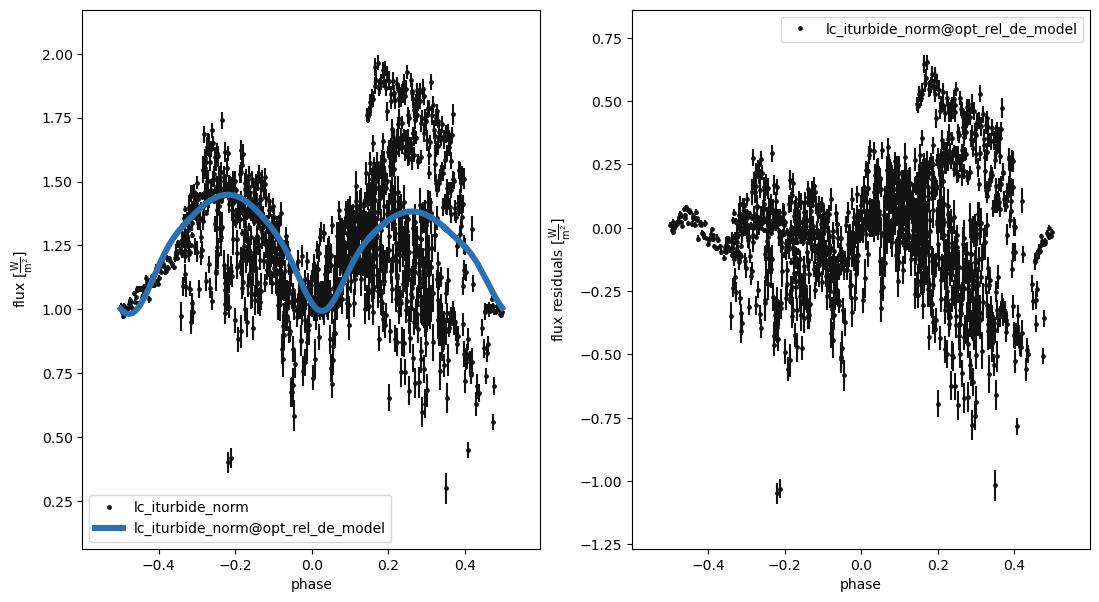

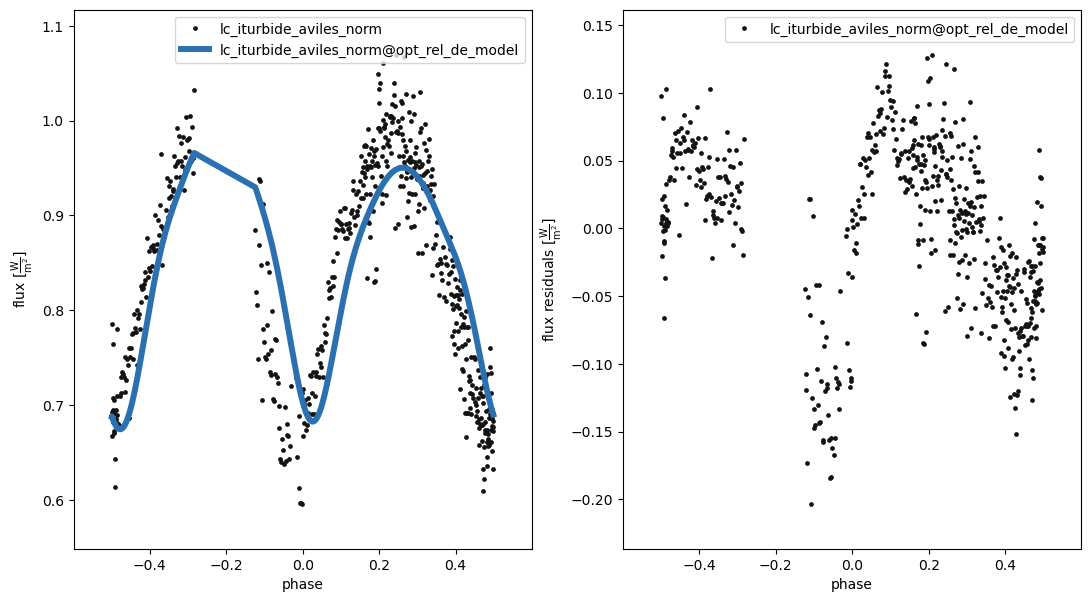

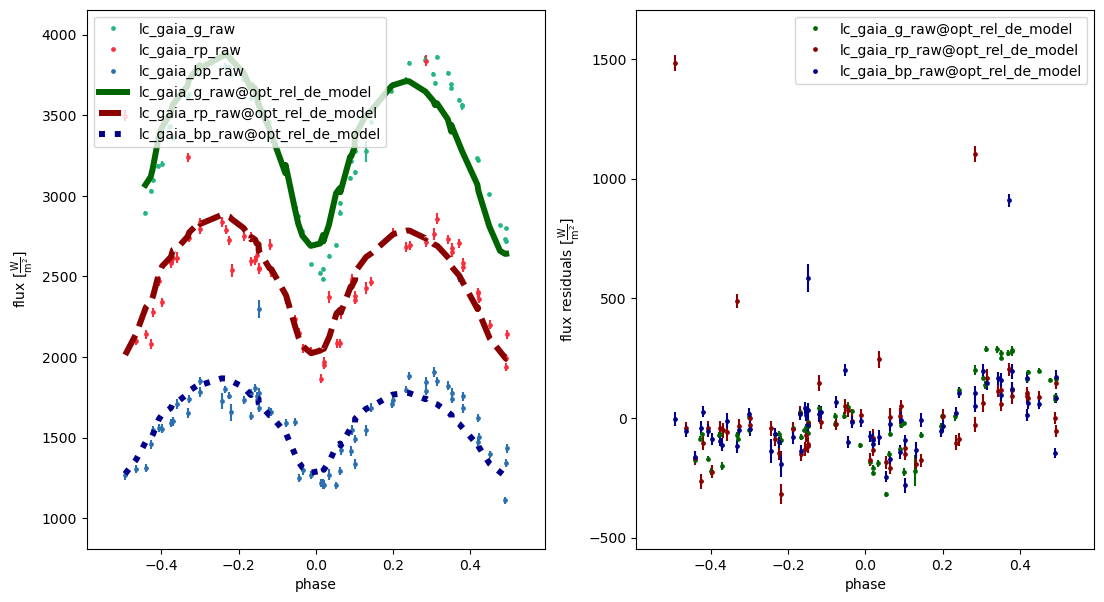

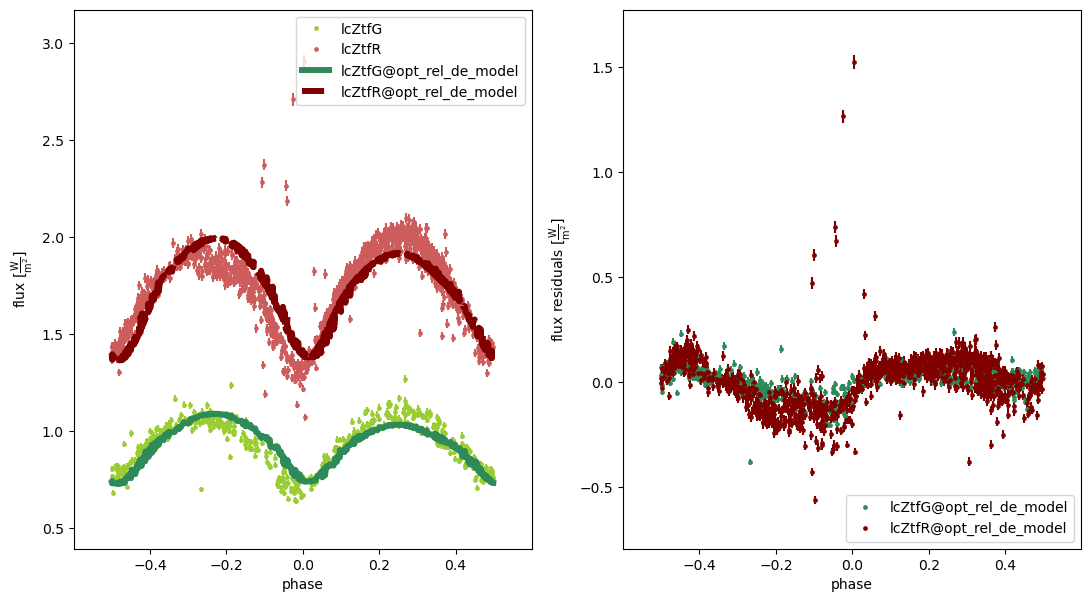

<Figure size 800x600 with 0 Axes>

In [ ]:
%%script echo "skipping; really bad residuals on both Gaia and ZTF now"

gen_utils.abilitateDatasets(b, ['lc_iturbide_norm', 'lc_iturbide_aviles_norm'] + ztfDatasets + rawGaiaDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/iturbide-gaia-ztf-relative_norm/results/opt_rel_de_solution", reset_params=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), model=computeModelName,
									datasetGroups=[['lc_iturbide_norm'], ['lc_iturbide_aviles_norm'], rawGaiaDatasets, ztfDatasets])
gen_utils.animateMesh(b, logger, model=computeModelName)

## Differential Corrections

In [40]:
from tqdm import tqdm

# progress bar generator
def generator():
    while True:
        yield

def gen_solution_path(solution: str) -> str:
    return os.path.join("external-jobs", "iturbide-gaia-ztf-relative_norm", "results", solution)

def run_dc_solver(b_dc: phoebe.Bundle, solver: str) -> None:
    PARAMS_FIT = len(b.get_value(qualifier='fit_parameters', solver=solver))
    THRESHOLD = np.ones(PARAMS_FIT) * 0.001

    solutionName = f"{solver}_solution"
    prevValues = np.ones(PARAMS_FIT) * np.inf

    for _ in tqdm(generator()):
        b_dc.run_solver(solver=solver, solution=solutionName, overwrite=True)
        curValues = np.asarray(b_dc.get_value(qualifier='fitted_values', solution=solutionName))
        gen_utils.printFittedVals(b_dc, solutionName)
        b_dc.adopt_solution(solutionName)

        print() # spacer
        
        ratio = curValues / prevValues
        curConvergence = np.abs(np.ones(PARAMS_FIT) - ratio)
        print(f"Convergence rate: {curConvergence}")
        print(f"Fit Chi2: {b_dc.get_value(qualifier='fitted_chi2', solution=solutionName)}")

        prevValues = curValues

        if (curConvergence <= THRESHOLD).all():
            b_dc.filter(context='solution', solution=solutionName, check_visible=False).save(gen_solution_path(solutionName), incl_uniqueid=True)
            break
        
    return solutionName

In [41]:
beforeDcBackup = b.copy()

Adopted:
teffratio@binary@orbit@component 0.93386  
incl@binary@orbit@component 66.54777 deg 

Original values:
  teffratio@binary@orbit@component 0.9675251414419437 
  incl@binary@orbit@component 71.0744196944225 deg 


100%|██████████| 3677/3677 [08:38<00:00,  7.09it/s]
Mon, 22 Jan 2024 17:03 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0008344892206263245 for dataset='lc_iturbide_aviles_norm'


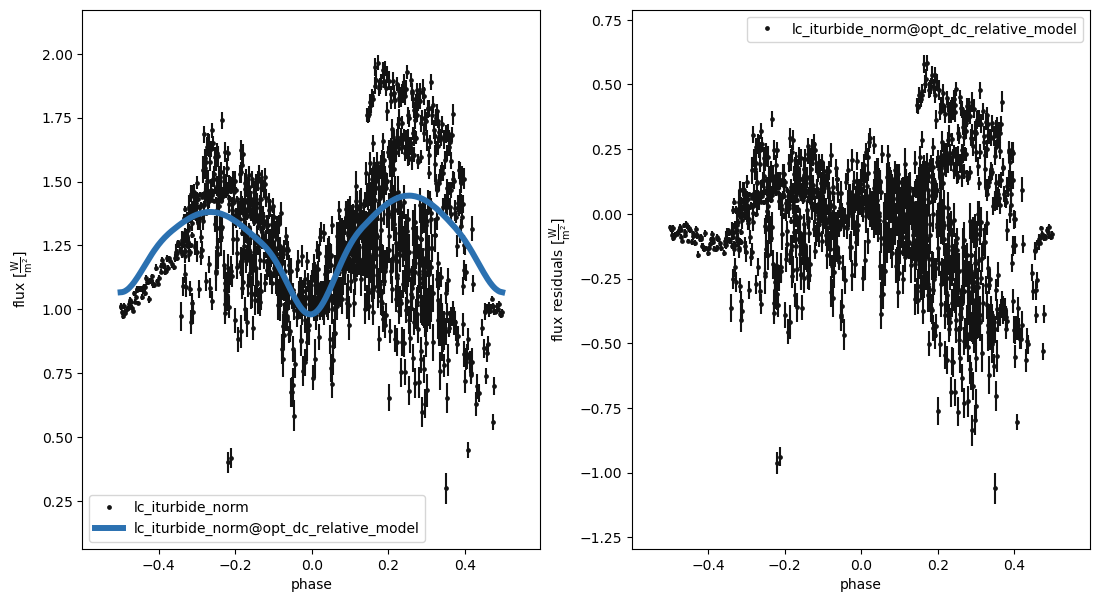

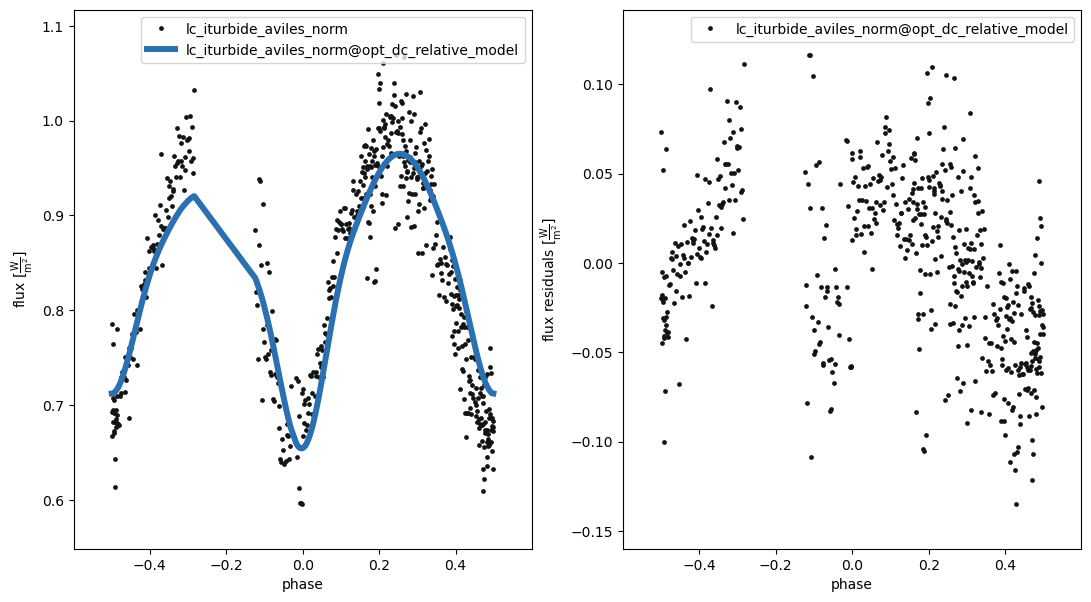

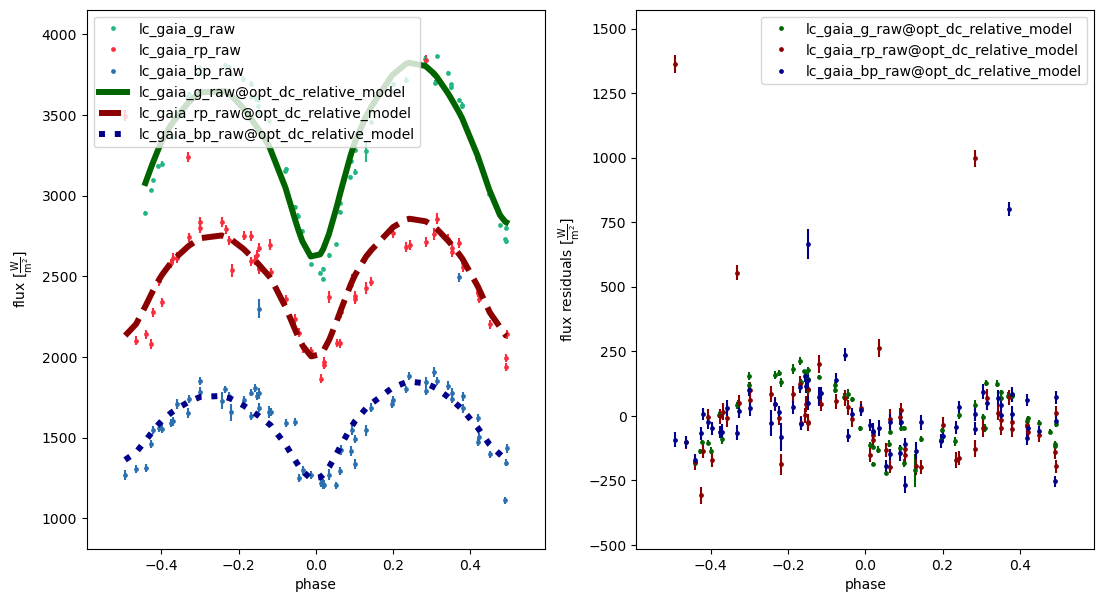

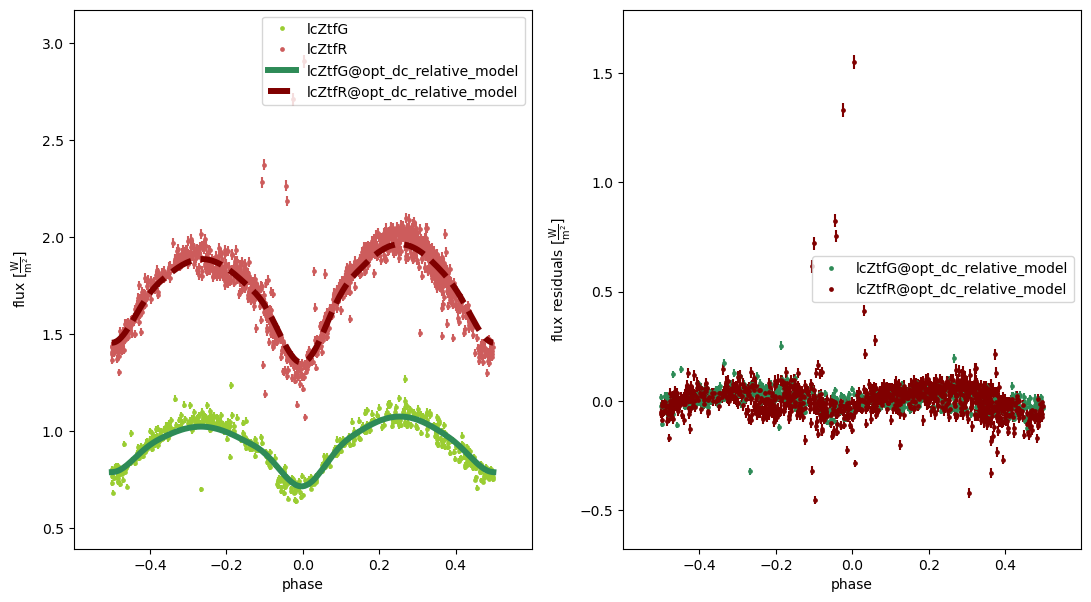

<Figure size 800x600 with 0 Axes>

In [42]:
# running locally, since this optimizer favors single-threaded speed and must be manually advanced per iteration

# b.add_solver('optimizer.differential_corrections', solver='dc_relative', fit_parameters=['teffratio', 'incl@binary', 'fillout_factor', 'period@binary', 't0_supconj@binary'], overwrite=True)
# b.add_solver('optimizer.differential_corrections', solver='dc_ff', fit_parameters=['fillout_factor'], overwrite=True)

dcSolver = "dc_relative"
dcSolution = "dc_relative_solution"
# dcSolver = "dc_ff"
# dcSolution = "dc_ff_solution"
if not os.path.exists(gen_solution_path(dcSolution)):
	dcBundle = b.copy()
	gen_utils.abilitateDatasets(dcBundle, trimmedZtfDatasets, False)
	dcSolution = run_dc_solver(dcBundle, dcSolver)
	print(dcSolution)

gen_utils.abilitateDatasets(b, ztfDatasets + rawGaiaDatasets + ['lc_iturbide_norm', 'lc_iturbide_aviles_norm'])
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file=gen_solution_path(dcSolution), reset_params=False)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[['lc_iturbide_norm'], ['lc_iturbide_aviles_norm'], rawGaiaDatasets, ztfDatasets], model=computeModelName)
gen_utils.animateMesh(b, logger, model=computeModelName)

# Adjusting Component $T_{eff}$

Since these parameters are some of the last that will likely need to be adjusted for this model, here we try adjusting the component $T_{eff}$ using the color
difference from each set of light curves. The optimized temperatures will need to agree with Gaia and ZTF data, since this is where we have color information.

Will run 3 separate optimizers; one including normalized datasets only (+ZTF), one including raw datasets only (-ZTF), and one with raw datasets + ZTF normalized.

In [43]:
pb_backup = b.copy()

In [56]:
%%script echo "skip unless need to restore from backup"
b = pb_backup.copy()

In [58]:
# coupling Gaia color LCs to Gaia_G
b.set_value_all(qualifier='pblum_mode', dataset=['lc_gaia_rp_raw', 'lc_gaia_bp_raw'], value='dataset-coupled')
b.set_value_all(qualifier='pblum_dataset', dataset=['lc_gaia_rp_raw', 'lc_gaia_bp_raw'], value='lc_gaia_g_raw')

b.set_value_all(qualifier='pblum_mode', dataset=['lc_gaia_rp_norm', 'lc_gaia_bp_norm'], value='dataset-coupled')
b.set_value_all(qualifier='pblum_dataset', dataset=['lc_gaia_rp_norm', 'lc_gaia_bp_norm'], value='lc_gaia_g_norm')

# coupling ZTF color to ZTF_G
b.set_value(qualifier='pblum_mode', dataset='lcZtfR', value='dataset-coupled')
b.set_value(qualifier='pblum_dataset', dataset='lcZtfR', value='lcZtfG')

b.set_value(qualifier='pblum_mode', dataset='lcZtfRTrimmed', value='dataset-coupled')
b.set_value(qualifier='pblum_dataset', dataset='lcZtfRTrimmed', value='lcZtfGTrimmed')

In [73]:
# hotfix for Gaia times
from astropy.time import Time

for gd in rawGaiaDatasets:
	times = Time(b.get_value(qualifier='times', dataset=gd, context='dataset'), format='jd', scale='tcb')
	b.set_value(qualifier='times', dataset=gd, context='dataset', value=times.utc.jd)

100%|██████████| 1075/1075 [02:23<00:00,  7.50it/s]


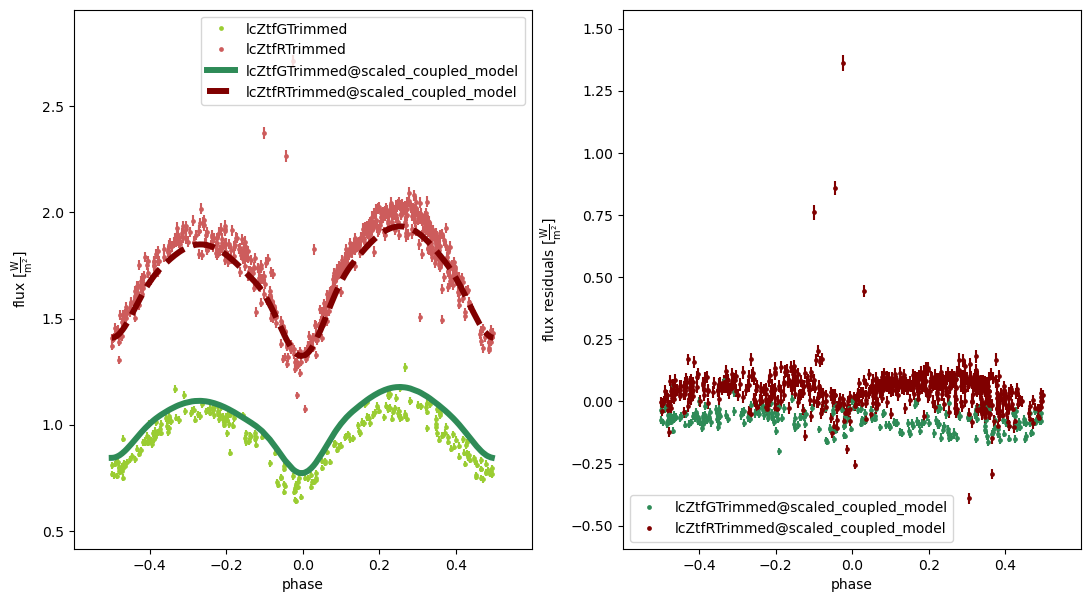

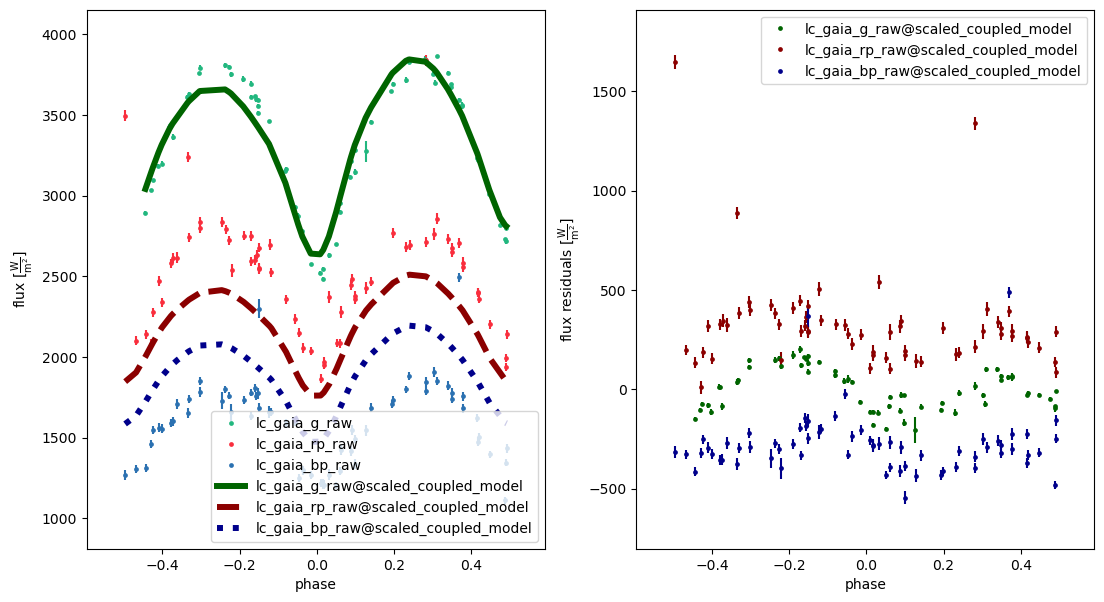

{'lcZtfGTrimmed-lcZtfRTrimmed': <Figure size 1300x700 with 2 Axes>,
 'lc_gaia_g_raw-lc_gaia_rp_raw-lc_gaia_bp_raw': <Figure size 1300x700 with 2 Axes>}

In [76]:
b.set_value(qualifier='teff', component='primary', context='component', value=4600*u.K)
b.set_value(qualifier='teffratio', value=0.9590370165831975)
gen_utils.abilitateDatasets(b, trimmedZtfDatasets + rawGaiaDatasets)
b.run_compute(model='scaled_coupled_model', overwrite=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[trimmedZtfDatasets, rawGaiaDatasets], model='scaled_coupled_model')

## Original Adjustment

Coupled all Gaia LCs together; **results in bad temperature adjustment**

In [24]:
%%script echo "skipping for following optimizer instead"
# normalized datasets; excluding Aviles norm (since it's a very sparse dataset)
opt_utils.optimize_params(b, label="teff_ff_pblum_iturbide_gaia_ztf_norm", export=True, subfolder="iturbide-gaia-ztf-relative_norm", overwrite_export=False,
						  fit_twigs=['teffratio', 'fillout_factor', 'teff@primary', 'pblum@primary@lc_gaia_g_norm', 'pblum@primary@lcZtfG', 'pblum@primary@lc_iturbide_norm'],
						  datasets=normGaiaDatasets + ztfDatasets + ['lc_iturbide_norm'], maxiter=500)

skipping for following optimizer instead


In [25]:
%%script echo "skipping for following optimizer instead"
solutionName, computeModelName = opt_utils.adopt_solution(b, 
													solution_file="./external-jobs/iturbide-gaia-ztf-relative_norm/results/opt_teff_ff_pblum_iturbide_gaia_ztf_norm_solution", 
													reset_params=True, dataset=['mesh01', 'lc_iturbide_norm'] + normGaiaDatasets + ztfDatasets)
gen_utils.plotModelResidualsFigsize(b, figsize=(17, 8), datasetGroups=[['lc_iturbide_norm'], normGaiaDatasets, ztfDatasets], model=computeModelName)
gen_utils.animateMesh(b, logger, model=computeModelName)

skipping for following optimizer instead


In [26]:
%%script echo "skipping for following optimizer instead"
# raw datasets only
opt_utils.optimize_params(b, label="teff_ff_pblum_iturbide_gaia_raw", export=True, subfolder="iturbide-gaia-ztf-ltt", 
						  fit_twigs=['teffratio', 'fillout_factor', 'teff@primary', 'pblum@primary@lc_gaia_g_raw', 'pblum@primary@lc_iturbide_raw'],
						  datasets=rawGaiaDatasets + ['lc_iturbide_raw'], maxiter=500)

skipping for following optimizer instead


In [27]:
%%script echo "skipping for following optimizer instead"
# raw + ZTF
opt_utils.optimize_params(b, label="teff_ff_pblum_iturbide_gaia_ztf_raw", export=True, subfolder="iturbide-gaia-ztf-ltt", 
						  fit_twigs=['teffratio', 'fillout_factor', 'teff@primary', 'pblum@primary@lc_gaia_g_raw', 'pblum@primary@lc_iturbide_raw', 'pblum@primary@lcZtfG'],
						  datasets=rawGaiaDatasets + ztfDatasets + ['lc_iturbide_raw'], maxiter=500)

skipping for following optimizer instead


## Adjusting Sets of Colors

3 different optimizers to determine component $T_{eff}$: using only Gaia color ($G - RP$ and $G - BP$), using only ZTF color ($G - R$), and one using both sets of light curves.

Only adjusting `teffratio`, `teff@primary`, and `pblum`; adjusting radii using `fillout_factor` should probably be done before changing passband scaling.

In [69]:
print(b['t0_supconj'])

Parameter: t0_supconj@binary@component
                       Qualifier: t0_supconj
                     Description: Zeropoint date at superior conjunction of the primary component
                           Value: -0.037542756559644994 d
                  Constrained by: 
                      Constrains: t0_perpass@binary@component, t0_ref@binary@component, compute_phases@lc_iturbide_norm@dataset, compute_phases@lc_iturbide_raw@dataset, compute_phases@lc_iturbide_aviles_norm@dataset, compute_phases@lc_iturbide_aviles_raw@dataset, compute_phases@lc_gaia_g_norm@dataset, compute_phases@lc_gaia_rp_norm@dataset, compute_phases@lc_gaia_bp_norm@dataset, compute_phases@lc_gaia_g_raw@dataset, compute_phases@lc_gaia_rp_raw@dataset, compute_phases@lc_gaia_bp_raw@dataset, compute_phases@lcZtfG@dataset, compute_phases@lcZtfR@dataset, compute_phases@lcZtfGTrimmed@dataset, compute_phases@lcZtfRTrimmed@dataset, compute_times@mesh01@dataset
                      Related to: period@binary@component, 

In [78]:
# ztf only
opt_utils.optimize_params(b, fit_twigs=['teffratio', 'teff@primary'], label='ztf_teff', export=True,overwrite_export=True,
						  datasets=trimmedZtfDatasets, subfolder='iturbide-gaia-ztf-relative_norm', maxiter=500)

# gaia + ztf
opt_utils.optimize_params(b, fit_twigs=['teffratio', 'teff@primary'], label='gaia_g_ztf_teff', export=True, overwrite_export=True,
						  datasets=rawGaiaDatasets + trimmedZtfDatasets, subfolder='iturbide-gaia-ztf-relative_norm', maxiter=500)

Solver already exists | ./external-jobs/iturbide-gaia-ztf-relative_norm/optimizer.nelder_mead_opt_gaia_g_teff.py
External Solver: ./external-jobs/iturbide-gaia-ztf-relative_norm/optimizer.nelder_mead_opt_ztf_teff.py ./results/opt_ztf_teff_solution
External Solver: ./external-jobs/iturbide-gaia-ztf-relative_norm/optimizer.nelder_mead_opt_gaia_g_ztf_teff.py ./results/opt_gaia_g_ztf_teff_solution


('opt_gaia_g_ztf_teff', 'opt_gaia_g_ztf_teff_solution')

Adopted:
teffratio@binary@orbit@component 0.94644  
teff@primary@star@component 4424.13654 K 

Original values:
  teffratio@binary@orbit@component 0.9590370165831975 
  teff@primary@star@component 4600.0 K 


100%|██████████| 1075/1075 [02:26<00:00,  7.32it/s]


opt_gaia_g_ztf_teff_model
	 Gaia (Raw) - 15386.764002431932
		 lc_gaia_g_raw - 4593.772223189687
		 lc_gaia_rp_raw - 5947.750247343898
		 lc_gaia_bp_raw - 4845.241531898346
------------------------------------------------
	 ZTF - 9602.093153545515
		 lcZtfG Not found in model
		 lcZtfR Not found in model
		 lcZtfGTrimmed - 1910.3915812551993
		 lcZtfRTrimmed - 7691.701572290316


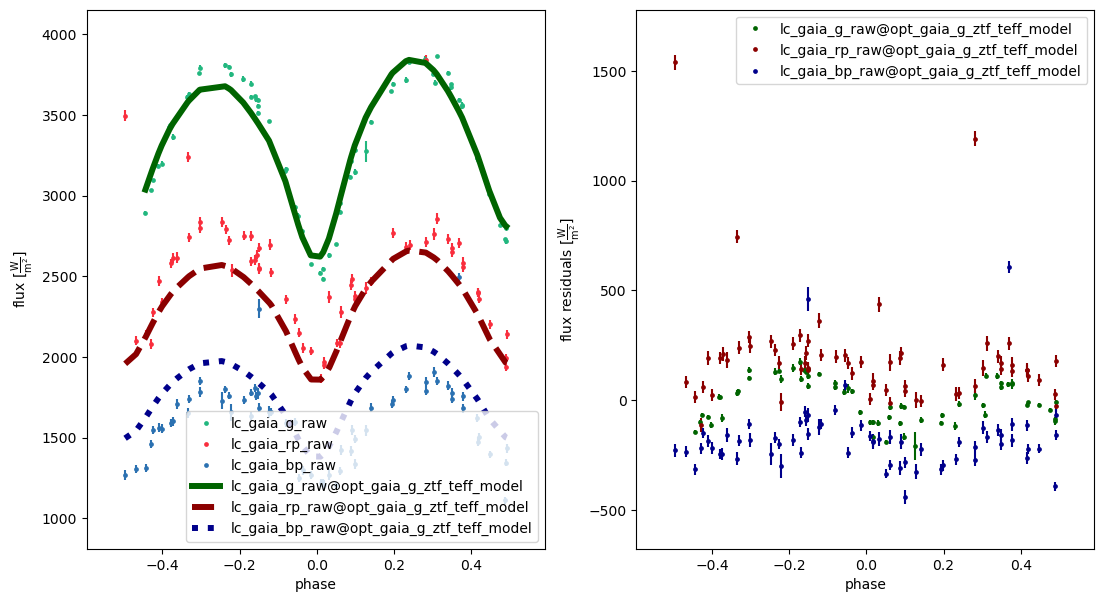

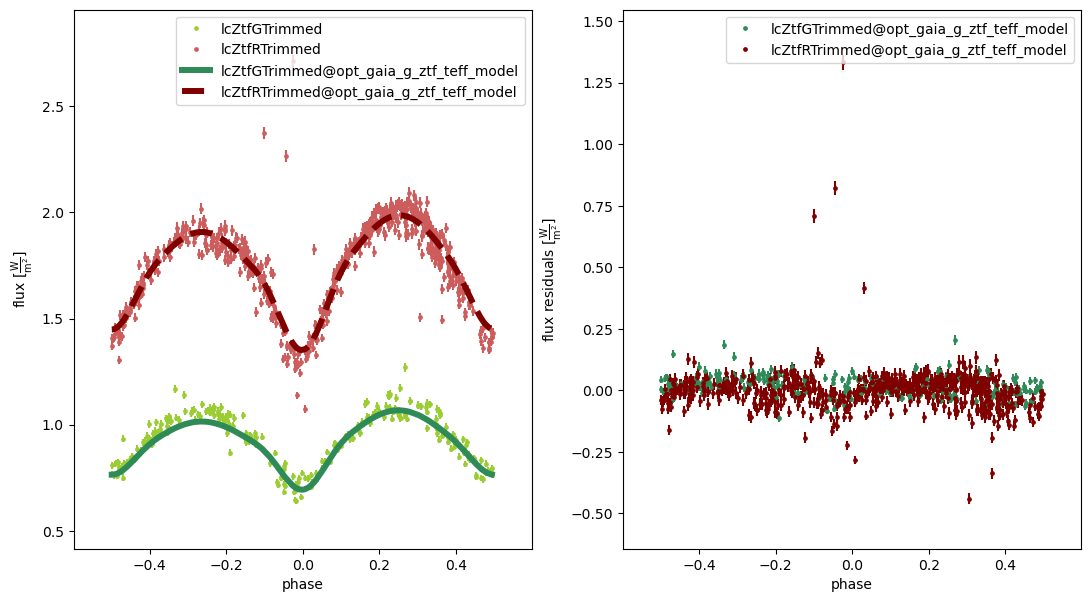

<Figure size 800x600 with 0 Axes>

In [85]:
# gaia + ztf
gen_utils.abilitateDatasets(b, rawGaiaDatasets + trimmedZtfDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/iturbide-gaia-ztf-relative_norm/results/opt_gaia_g_ztf_teff_solution", reset_params=True)
gen_utils.printChi2(b, computeModelName)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[rawGaiaDatasets, trimmedZtfDatasets], model=computeModelName)
gen_utils.animateMesh(b, logger, model=computeModelName)

Adopted:
teffratio@binary@orbit@component 0.94360  
teff@primary@star@component 4468.08971 K 

Original values:
  teffratio@binary@orbit@component 0.9590370165831975 
  teff@primary@star@component 4600.0 K 


100%|██████████| 1075/1075 [02:30<00:00,  7.16it/s]


opt_ztf_teff_model
	 Gaia (Raw) - 16744.903892124028
		 lc_gaia_g_raw - 4549.928191420752
		 lc_gaia_rp_raw - 6642.947341923233
		 lc_gaia_bp_raw - 5552.028358780045
------------------------------------------------
	 ZTF - 9224.672014992479
		 lcZtfG Not found in model
		 lcZtfR Not found in model
		 lcZtfGTrimmed - 1589.0016039629968
		 lcZtfRTrimmed - 7635.670411029481


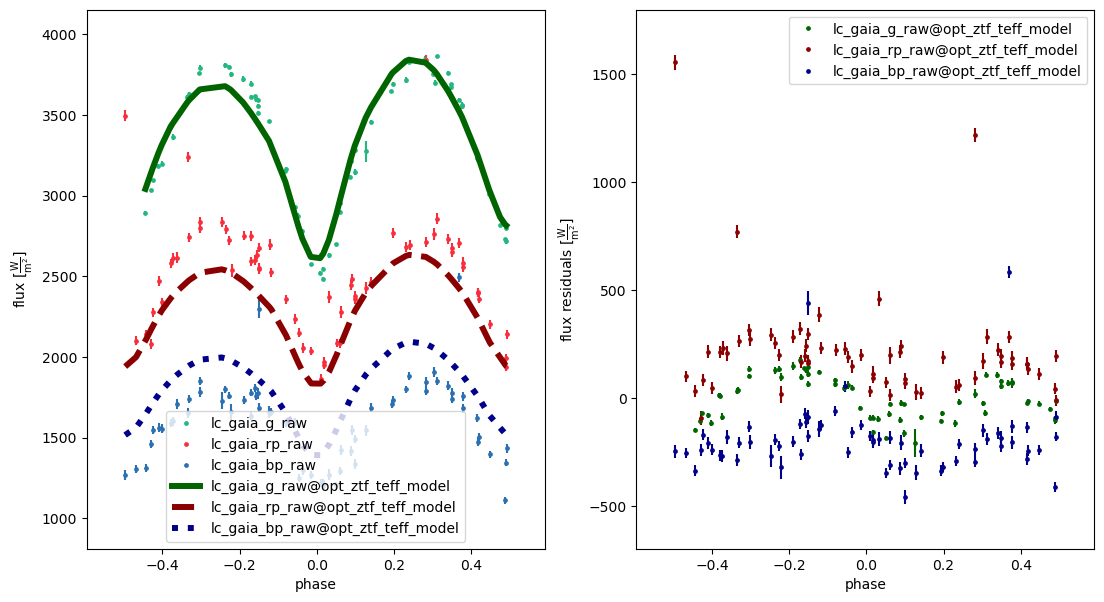

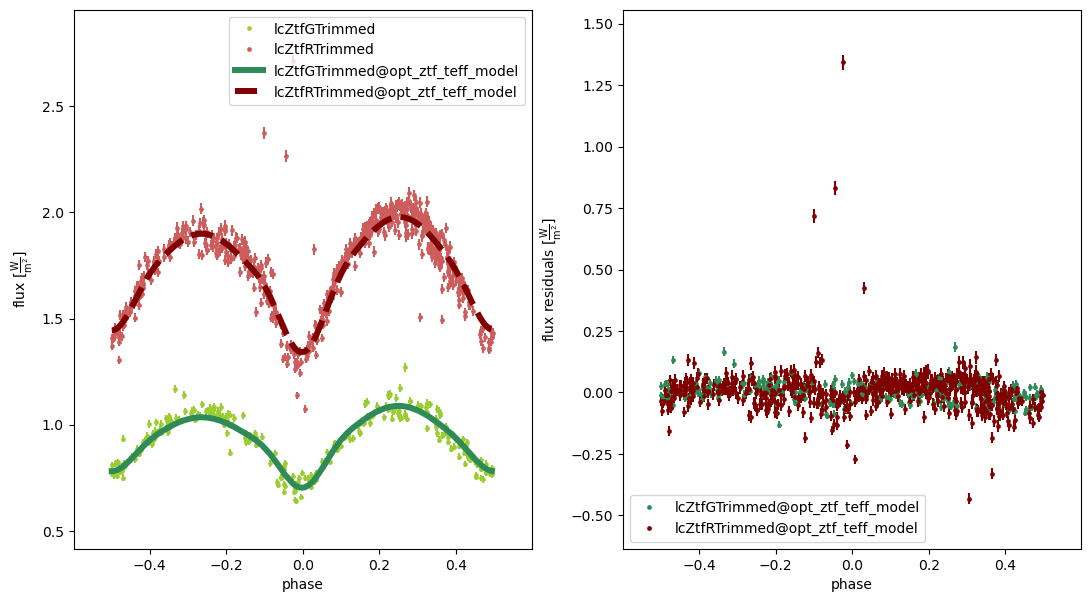

<Figure size 800x600 with 0 Axes>

In [86]:
# ztf only
gen_utils.abilitateDatasets(b, rawGaiaDatasets + trimmedZtfDatasets)

solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/iturbide-gaia-ztf-relative_norm/results/opt_ztf_teff_solution", reset_params=True)
gen_utils.printChi2(b, computeModelName)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[rawGaiaDatasets, trimmedZtfDatasets], model=computeModelName)
gen_utils.animateMesh(b, logger, model=computeModelName, color='inferno')

## Adopt Chosen Solution

In [96]:
# adopting ZTF only optimization run
	# slightly worse fit to Gaia data, but this is expected since there seems to be a systematic effect I'm not taking into account
print(b.adopt_solution(solution='opt_ztf_teff_solution'))

ParameterSet: 2 parameters
       teffratio@binary@component: 0.9435997651603403
           teff@primary@component: 4468.089709381677 K


# `pblum` Optimization

In [102]:
b.set_value_all(qualifier='pblum_mode', dataset=['lc_gaia_g_raw', 'lcZtfG', 'lcZtfGTrimmed'], value='component-coupled')
print(b['pblum_mode'])
print(b['pblum'])

ParameterSet: 9 parameters
   pblum_mode@lc_iturbide_norm...: dataset-scaled
   pblum_mode@lc_iturbide_avil...: dataset-scaled
   pblum_mode@lc_gaia_g_raw@da...: component-coupled
   pblum_mode@lc_gaia_rp_raw@d...: dataset-coupled
   pblum_mode@lc_gaia_bp_raw@d...: dataset-coupled
        pblum_mode@lcZtfG@dataset: component-coupled
        pblum_mode@lcZtfR@dataset: dataset-coupled
   pblum_mode@lcZtfGTrimmed@da...: component-coupled
   pblum_mode@lcZtfRTrimmed@da...: dataset-coupled
ParameterSet: 3 parameters
   pblum@primary@lc_gaia_g_raw...: 12.566370614359172 W
     pblum@primary@lcZtfG@dataset: 12.566370614359172 W
   pblum@primary@lcZtfGTrimmed...: 12.566370614359172 W


## ZTF

 75%|███████▌  | 15/20 [1:48:40<36:13, 434.70s/it]  


Adopted:
pblum@primary@lcZtfG@lc@dataset 6.00250 W 

Original values:
  pblum@primary@lcZtfG@lc@dataset 5.846833829621264 W 


100%|██████████| 1715/1715 [03:54<00:00,  7.31it/s]


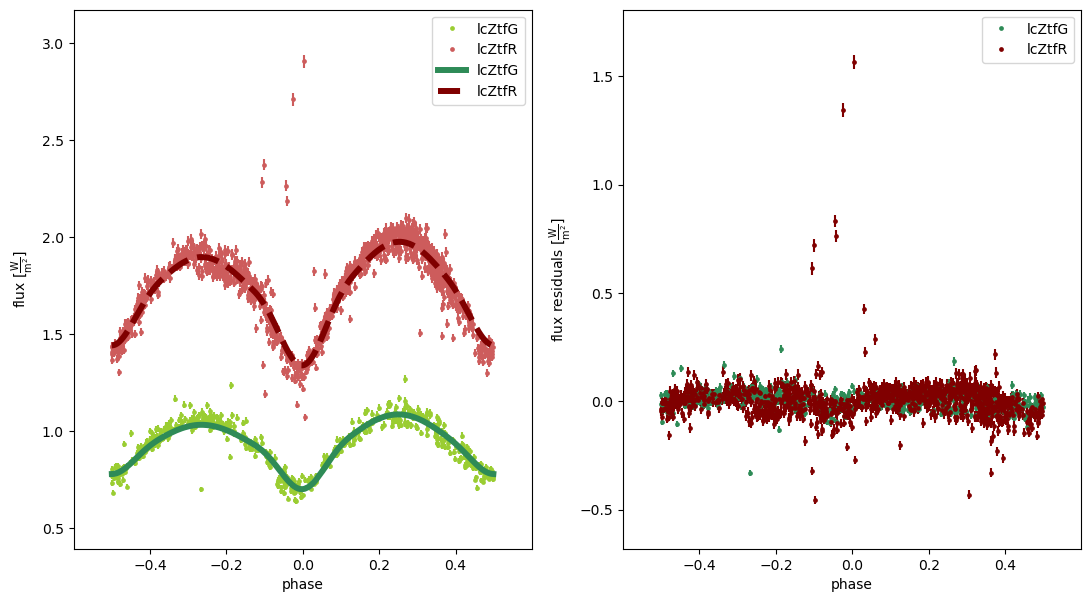

{'lcZtfG-lcZtfR': <Figure size 1300x700 with 2 Axes>}

In [106]:
# final adjustment of ZTF pblum; need to adjust due to new teffratio used
solutionPath = gen_solution_path('ztf_pblum_local')
if not os.path.exists(solutionPath):
	_, solutionName = opt_utils.optimize_params(b, ['pblum@primary@lcZtfG@dataset'], label='ztf_pblum', export=False, datasets=ztfDatasets, maxiter=20)
	b.filter(context='solution', solution=solutionName, check_visible=False).save(solutionPath, incl_uniqueid=True)

gen_utils.abilitateDatasets(b, enableDatasets=ztfDatasets, includeMesh=False)
_, computeModelName = opt_utils.adopt_solution(b, reset_params=False, solution_file=solutionPath)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[ztfDatasets], model=computeModelName)
# gen_utils.animateMesh(b, logger, model=computeModelName)

100%|██████████| 858/858 [02:05<00:00,  6.83it/s]


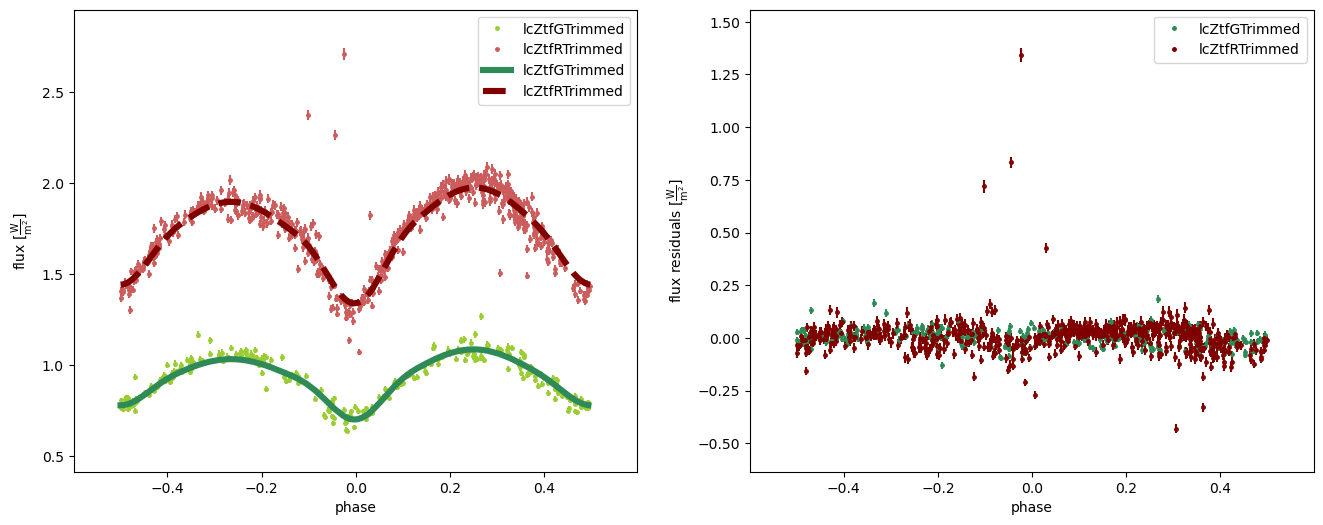

{'lcZtfGTrimmed-lcZtfRTrimmed': <Figure size 1600x600 with 2 Axes>}

In [112]:
b.set_value(qualifier='pblum', dataset='lcZtfGTrimmed', value=b.get_value(qualifier='pblum', dataset='lcZtfG'))
gen_utils.abilitateDatasets(b, trimmedZtfDatasets, False)
b.run_compute(model='trimmed_after_opt', overwrite=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(16, 6), datasetGroups=[trimmedZtfDatasets], model='trimmed_after_opt')

## Iturbide

In [90]:
%%script echo "skipping; won't be using this light curve for sampling"

# norm full
solutionPath = gen_solution_path('iturbide_norm_pblum_local')
if not os.path.exists(solutionPath):
	_, solutionName = opt_utils.optimize_params(b, ['pblum@primary@lc_iturbide_norm@dataset'], label='iturbide_norm_pblum', export=False, datasets=['lc_iturbide_norm'], maxiter=40)
	b.filter(context='solution', solution=solutionName, check_visible=False).save(solutionPath, incl_uniqueid=True)

_, computeModelName = opt_utils.adopt_solution(b, reset_params=False, solution_file=solutionPath)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=['lc_iturbide_norm'], model=computeModelName)

skipping; keeping dataset-scaled for main datasets, avoiding adjusting for passband luminosity


In [91]:
%%script echo "skipping; won't be using this light curve for sampling"

# norm Aviles
solutionPath = gen_solution_path('iturbide_aviles_norm_pblum_local')
if not os.path.exists(solutionPath):
	_, solutionName = opt_utils.optimize_params(b, ['pblum@primary@lc_iturbide_aviles_norm@dataset'], label='iturbide_aviles_norm_pblum', export=False, 
											 	datasets=['lc_iturbide_aviles_norm'], maxiter=40)
	b.filter(context='solution', solution=solutionName, check_visible=False).save(solutionPath, incl_uniqueid=True)

_, computeModelName = opt_utils.adopt_solution(b, reset_params=False, solution_file=solutionPath)
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=['lc_iturbide_aviles_norm'], model=computeModelName)

skipping; keeping dataset-scaled for main datasets, avoiding adjusting for passband luminosity


## Gaia

### Normalized data

In [94]:
%%script echo "skipping; not using Gaia normalized data"

gen_utils.abilitateDatasets(b, normGaiaDatasets)
b.run_compute(model='gaia_g_coupled', overwrite=True)
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[normGaiaDatasets], model='gaia_g_coupled')

skipping; keeping dataset-scaled for main datasets, avoiding adjusting for passband luminosity


### Raw data

100%|██████████| 40/40 [13:31<00:00, 20.28s/it]


Adopted:
pblum@primary@lc_gaia_g_raw@lc@dataset 19871.46171 W 

Original values:
  pblum@primary@lc_gaia_g_raw@lc@dataset 12.566370614359172 W 


100%|██████████| 217/217 [00:29<00:00,  7.34it/s]


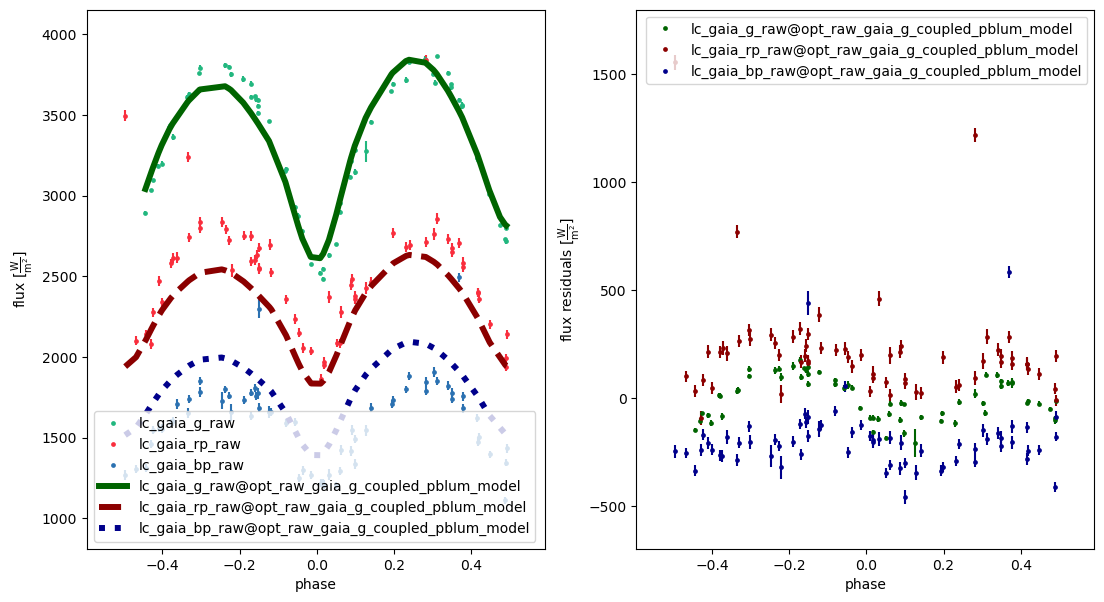

{'lc_gaia_g_raw-lc_gaia_rp_raw-lc_gaia_bp_raw': <Figure size 1300x700 with 2 Axes>}

In [107]:
# optimize passband luminosity
solutionPath = gen_solution_path('raw_gaia_g_coupled_pblum_local')
if not os.path.exists(solutionPath):
	_, solutionName = opt_utils.optimize_params(b, ['pblum@primary@lc_gaia_g_raw@dataset'], label='raw_gaia_g_coupled_pblum', export=False, 
											 	datasets=['lc_gaia_g_raw'], maxiter=40)
	b.filter(context='solution', solution=solutionName, check_visible=False).save(solutionPath, incl_uniqueid=True)

gen_utils.abilitateDatasets(b, rawGaiaDatasets)
_, computeModelName = opt_utils.adopt_solution(b, reset_params=False, solution_file=solutionPath)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[rawGaiaDatasets], model=computeModelName)

# Clean Up Bundle

Remove models, datasets, and solutions that are no longer useful. Reduce bundle size for loading into MCMC sampling phase.

In [113]:
b.models, b.datasets, b.solutions

(['trimmed_after_opt'],
 ['mesh01',
  'lc_iturbide_norm',
  'lc_iturbide_aviles_norm',
  'lc_gaia_g_raw',
  'lc_gaia_rp_raw',
  'lc_gaia_bp_raw',
  'lcZtfG',
  'lcZtfR',
  'lcZtfGTrimmed',
  'lcZtfRTrimmed'],
 [])

In [114]:
b.remove_solutions_all()
b.remove_models_all()

keepDatasets = ['mesh01', 'lc_iturbide_norm', 'lc_iturbide_aviles_norm'] + rawGaiaDatasets + ztfDatasets + trimmedZtfDatasets
for d in b.datasets:
	if d not in keepDatasets:
		b.remove_dataset(d)

b.models, b.datasets, b.solutions

([],
 ['mesh01',
  'lc_iturbide_norm',
  'lc_iturbide_aviles_norm',
  'lc_gaia_g_raw',
  'lc_gaia_rp_raw',
  'lc_gaia_bp_raw',
  'lcZtfG',
  'lcZtfR',
  'lcZtfGTrimmed',
  'lcZtfRTrimmed'],
 [])

In [115]:
gen_utils.saveBundle(b, bundleName="post-optimizers", subfolder="iturbide-gaia-ztf-relative_norm")

CAUTION: overwriting bundle-saves/iturbide-gaia-ztf-relative_norm/post-optimizers


'bundle-saves/iturbide-gaia-ztf-relative_norm/post-optimizers'

# Testing Interstellar Extinction

In [68]:
b = phoebe.load("./bundle-saves/iturbide-gaia-ztf-relative_norm/post-optimizers")

In [4]:
print(b['ebv'])
print(b['Av'])
print(b['Rv'])
print(b['distance'])

ParameterSet: 2 parameters
C                      ebv@system: 0.0
                   ebv@constraint: {Av@system} / {Rv@system}
Parameter: Av@system
                       Qualifier: Av
                     Description: Extinction Av
                           Value: 0.0
                  Constrained by: 
                      Constrains: ebv@system
                      Related to: Rv@system, ebv@system

Parameter: Rv@system
                       Qualifier: Rv
                     Description: Extinction law parameter
                           Value: 3.1
                  Constrained by: 
                      Constrains: ebv@system
                      Related to: Av@system, ebv@system

Parameter: distance@system
                       Qualifier: distance
                     Description: Distance to the system
                           Value: 1.0 m
                  Constrained by: 
                      Constrains: None
                      Related to: None



100%|██████████| 1075/1075 [02:37<00:00,  6.81it/s]


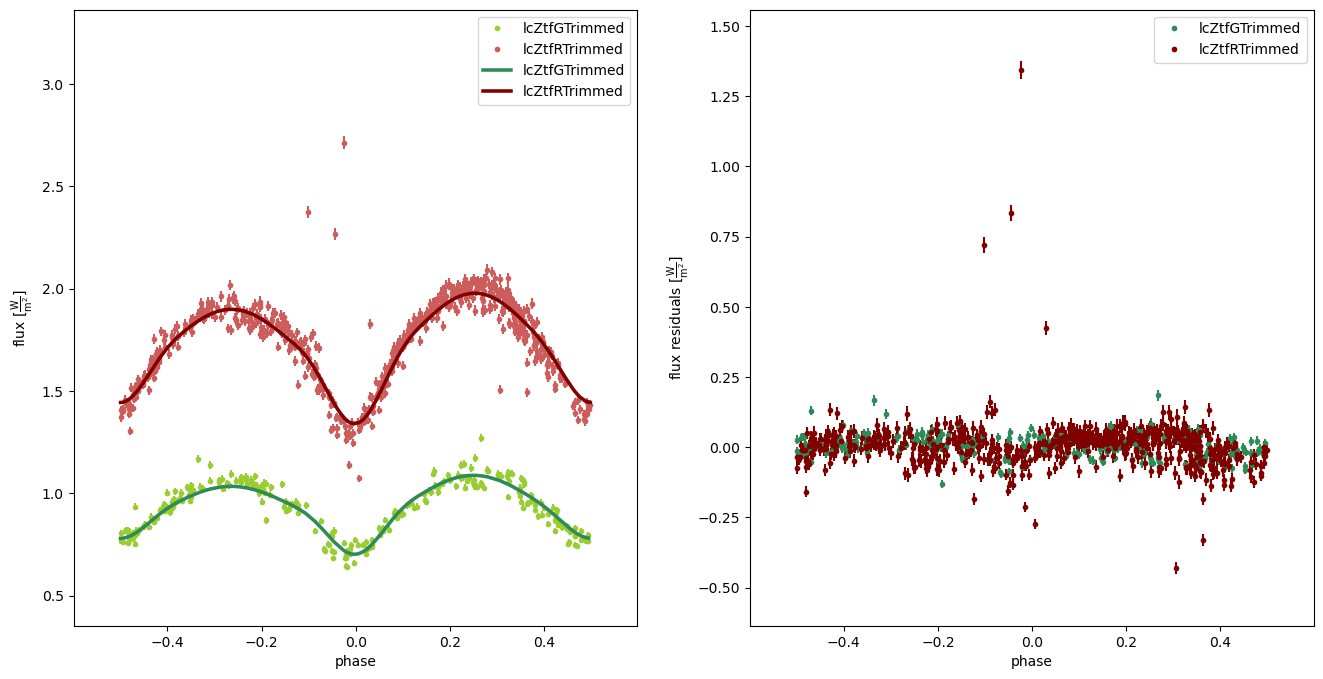

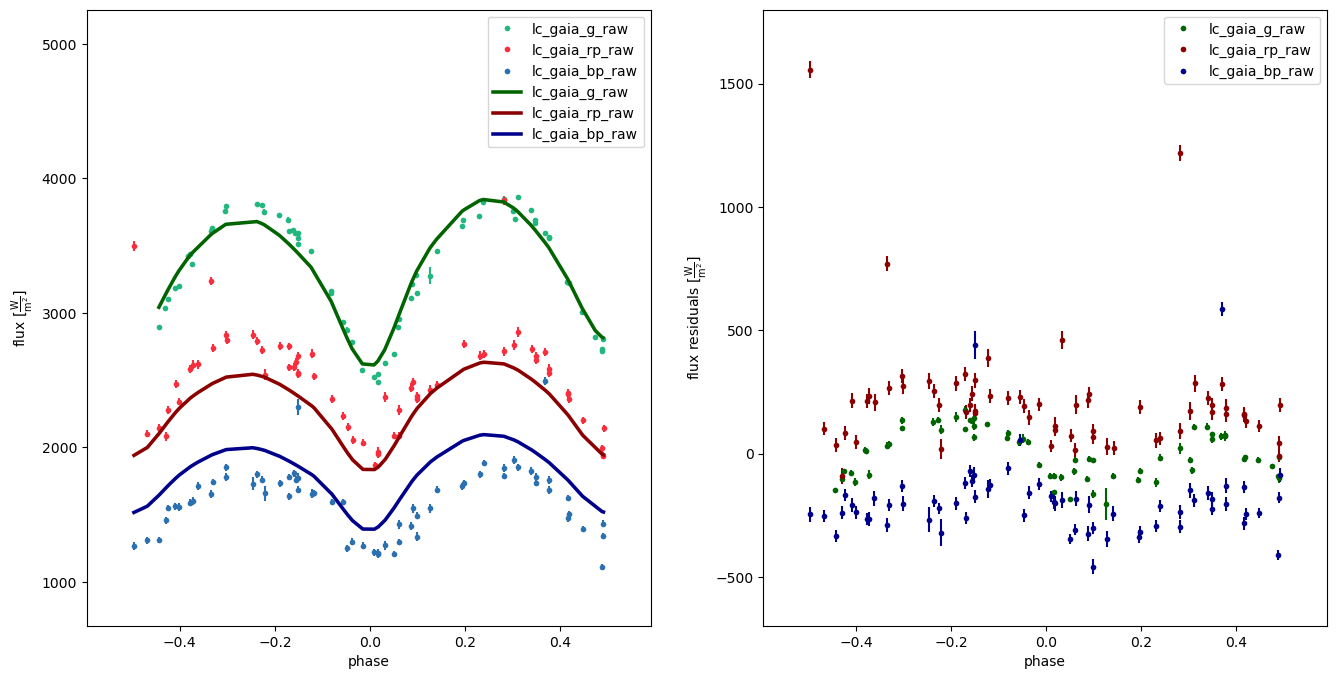

{'lcZtfGTrimmed-lcZtfRTrimmed': <Figure size 1600x800 with 2 Axes>,
 'lc_gaia_g_raw-lc_gaia_rp_raw-lc_gaia_bp_raw': <Figure size 1600x800 with 2 Axes>}

In [5]:
gen_utils.abilitateDatasets(b, trimmedZtfDatasets + rawGaiaDatasets)
b.run_compute(model='no_extinction_model', overwrite=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(16, 8), datasetGroups=[trimmedZtfDatasets, rawGaiaDatasets], model='no_extinction_model')

In [69]:
b.flip_constraint(qualifier='ebv', solve_for='Av')

<ConstraintParameter: {Av@system} = {Rv@system} * {ebv@system} (solar units) => 0.0>

In [70]:
# Schlafly & Finkbeiner 2011 (ApJ 737, 103)
	# uses R = 3.1 (average galactic extinction)
# b.set_value(qualifier='ebv', value=0.1256) # IRSA SF (2011) mean: https://irsa.ipac.caltech.edu/cgi-bin/bgTools/nph-bgExec
# b.set_value(qualifier='ebv', value=0.1312) # IRSA SF (2011) max value
# b.set_value(qualifier='ebv', value=0.1238) # IRSA SF (2011) min value

# b.set_value(qualifier='ebv', value=0.1460) # IRSA SFD (1998) mean
b.set_value(qualifier='ebv', value=0.1526) # IRSA SFD (1998) max

# distance from Bailer -Jones (2021)
# b.set_value(qualifier='distance', value=2256.9956*u.pc)

In [72]:
b.remove_dataset('lc_iturbide_norm')
b.remove_dataset('lc_iturbide_aviles_norm')
b.remove_dataset('lcZtfG')
b.remove_dataset('lcZtfR')
b.remove_dataset('lcZtfGTrimmed')
b.remove_dataset('lcZtfRTrimmed')

<ParameterSet: 47 parameters | contexts: figure, dataset, constraint, compute>

In [64]:
print(b['ebv'])
print(b['Av'])
print(b['Rv'])
print(b['distance'])

Parameter: ebv@system
                       Qualifier: ebv
                     Description: Extinction E(B-V)
                           Value: 0.1526
                  Constrained by: 
                      Constrains: Av@system
                      Related to: Av@system, Rv@system

ParameterSet: 2 parameters
C                       Av@system: 0.38378
                    Av@constraint: {Rv@system} * {ebv@system}
Parameter: Rv@system
                       Qualifier: Rv
                     Description: Extinction law parameter
                           Value: 3.1
                  Constrained by: 
                      Constrains: Av@system
                      Related to: Av@system, ebv@system

Parameter: distance@system
                       Qualifier: distance
                     Description: Distance to the system
                           Value: 1.0 m
                  Constrained by: 
                      Constrains: None
                      Related to: None



Mon, 22 Apr 2024 22:07 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
100%|██████████| 217/217 [00:31<00:00,  6.92it/s]


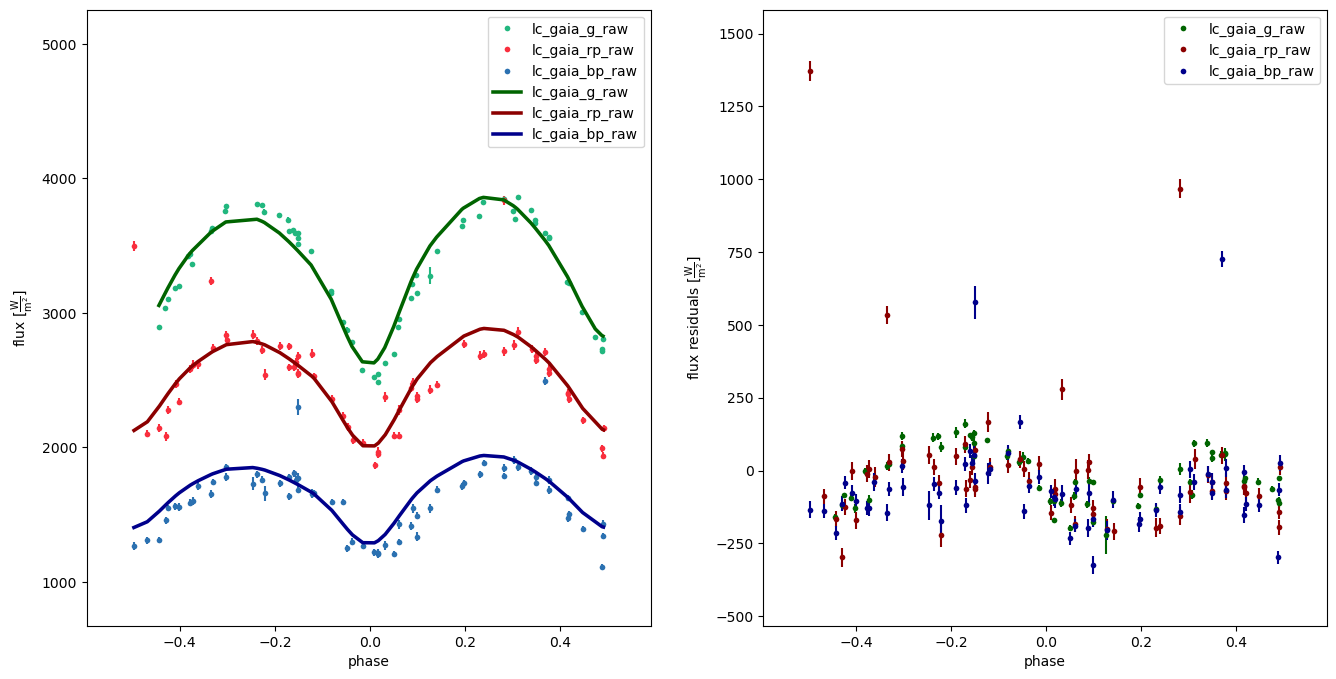

{'lc_gaia_g_raw-lc_gaia_rp_raw-lc_gaia_bp_raw': <Figure size 1600x800 with 2 Axes>}

In [73]:
gen_utils.abilitateDatasets(b, rawGaiaDatasets)
b.run_compute(model='s_f_extinction_model', overwrite=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(16, 8), datasetGroups=[rawGaiaDatasets], model='s_f_extinction_model')

In [66]:
if 'opt_pblum_ext' in b.solvers:
	b.remove_solver('opt_pblum_ext')
	b.remove_solution('opt_pblum_ext_solution')
opt_utils.optimize_params(b, fit_twigs=['pblum@primary@lc_gaia_g_raw'], label='pblum_ext', export=False, datasets=['lc_gaia_g_raw'], maxiter=5)

Mon, 22 Apr 2024 22:00 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
  0%|          | 0/5 [00:00<?, ?it/s]Mon, 22 Apr 2024 22:00 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
Mon, 22 Apr 2024 22:00 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
Mon, 22 Apr 2024 22:01 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
Mon, 22 Apr 2024 22:01 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
 40

('opt_pblum_ext', 'opt_pblum_ext_solution')

In [67]:
print(b['opt_pblum_ext_solution'])

ParameterSet: 11 parameters
R  fitted_twigs@opt_pblum_ext_...: ['pblum@primary@lc_gaia_g_raw@lc@dataset']
   adopt_parameters@opt_pblum_...: ['pblum@primary@lc_gaia_g_raw@lc@dataset']
   adopt_distributions@opt_pbl...: False
   adopt_values@opt_pblum_ext_...: True
R  message@opt_pblum_ext_solut...: Maximum number of iterations has been exceeded.
R  niter@opt_pblum_ext_solutio...: 5
R  success@opt_pblum_ext_solut...: False
R  initial_values@opt_pblum_ex...: [19809.36339099145]
R  fitted_values@opt_pblum_ext...: [19809.36339099145]
R  fitted_units@opt_pblum_ext_...: ['W']
   comments@opt_pblum_ext_solu...: 


Adopted:
pblum@primary@lc_gaia_g_raw@lc@dataset 19809.36339 W 

Original values:


Mon, 22 Apr 2024 19:20 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.


  pblum@primary@lc_gaia_g_raw@lc@dataset 19871.46171 W 


100%|██████████| 217/217 [00:32<00:00,  6.59it/s]


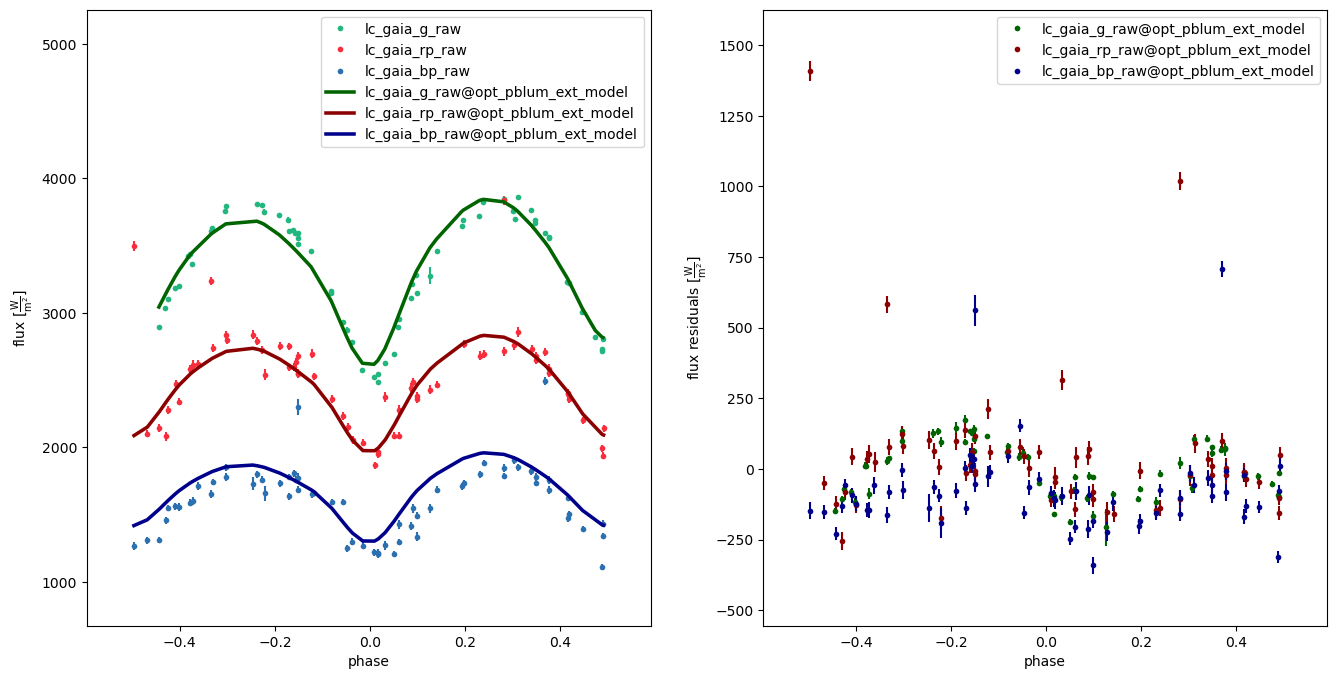

{'lc_gaia_g_raw-lc_gaia_rp_raw-lc_gaia_bp_raw': <Figure size 1600x800 with 2 Axes>}

In [52]:
gen_utils.abilitateDatasets(b, rawGaiaDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, label='pblum_ext', reset_params=False)
gen_utils.plotModelResidualsFigsize(b, figsize=(16, 8), datasetGroups=[rawGaiaDatasets], model=computeModelName)